In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
ravdess_path = kagglehub.dataset_download('uwrfkaggler/ravdess-emotional-speech-audio')
tess_path = kagglehub.dataset_download('ejlok1/toronto-emotional-speech-set-tess')
cremad_path = kagglehub.dataset_download('ejlok1/cremad')
savee_path = kagglehub.dataset_download('ejlok1/surrey-audiovisual-expressed-emotion-savee')

print('Data source import complete.')


Data source import complete.


# Import Libraries

In [ ]:
!pip install torchinfo

# === Standard Libraries ===
import os
import sys
import random
import warnings
from concurrent.futures import ThreadPoolExecutor

# === Data Handling ===
import numpy as np
import pandas as pd

# === Visualization ===
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

# === Audio Processing ===
import librosa
import librosa.display
import torchaudio
import torchaudio.transforms as T

# === IPython Utilities (e.g., for audio playback in notebooks) ===
from IPython.display import Audio

# === Sklearn ===
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# === PyTorch ===
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary

# === Progress Bars ===
from tqdm import tqdm

# === Warnings Configuration ===
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Data Preprocessing

In [ ]:
TESS = tess_path + "/TESS Toronto emotional speech set data/"
RAVDESS = ravdess_path + "/"
SAVEE = savee_path+ "/ALL/"
CREMA = cremad_path + "/AudioWAV/"

## RAVDESS

In [ ]:
dir_list = os.listdir(RAVDESS)
dir_list.sort()

emotion = []
gender = []
path = []
for i in dir_list:
    if i == 'audio_speech_actors_01-24':
        break
    fname = os.listdir(RAVDESS + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        #print(part[2])
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVDESS + i + '/' + f)


Ravdess_df = pd.DataFrame(emotion)
Ravdess_df = Ravdess_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
Ravdess_df = pd.concat([pd.DataFrame(gender),Ravdess_df],axis=1)
Ravdess_df.columns = ['gender','emotion']
Ravdess_df['labels'] =Ravdess_df.gender + '_' + Ravdess_df.emotion
Ravdess_df['source'] = 'RAVDESS'
Ravdess_df = pd.concat([Ravdess_df,pd.DataFrame(path, columns = ['path'])],axis=1)
Ravdess_df = Ravdess_df.drop(['gender', 'emotion'], axis=1)
Ravdess_df.labels.value_counts()

,count
labels,
male_neutral,144
female_neutral,144
male_fear,96
male_happy,96
male_disgust,96
male_sad,96
male_angry,96
male_surprise,96
female_surprise,96


## CREMA

In [ ]:
dir_list = os.listdir(CREMA)
dir_list.sort()
gender = []
emotion = []
path = []
female = [1002,1003,1004,1006,1007,1008,1009,1010,1012,1013,1018,1020,1021,1024,1025,1028,1029,1030,1037,1043,1046,1047,1049,
          1052,1053,1054,1055,1056,1058,1060,1061,1063,1072,1073,1074,1075,1076,1078,1079,1082,1084,1089,1091]

for i in dir_list:
    part = i.split('_')
    if int(part[0]) in female:
        temp = 'female'
    else:
        temp = 'male'
    gender.append(temp)
    if part[2] == 'SAD' and temp == 'male':
        emotion.append('male_sad')
    elif part[2] == 'ANG' and temp == 'male':
        emotion.append('male_angry')
    elif part[2] == 'DIS' and temp == 'male':
        emotion.append('male_disgust')
    elif part[2] == 'FEA' and temp == 'male':
        emotion.append('male_fear')
    elif part[2] == 'HAP' and temp == 'male':
        emotion.append('male_happy')
    elif part[2] == 'NEU' and temp == 'male':
        emotion.append('male_neutral')
    elif part[2] == 'SAD' and temp == 'female':
        emotion.append('female_sad')
    elif part[2] == 'ANG' and temp == 'female':
        emotion.append('female_angry')
    elif part[2] == 'DIS' and temp == 'female':
        emotion.append('female_disgust')
    elif part[2] == 'FEA' and temp == 'female':
        emotion.append('female_fear')
    elif part[2] == 'HAP' and temp == 'female':
        emotion.append('female_happy')
    elif part[2] == 'NEU' and temp == 'female':
        emotion.append('female_neutral')
    else:
        emotion.append('Unknown')
    path.append(CREMA + i)

CREMA_df = pd.DataFrame(emotion, columns = ['labels'])
CREMA_df['source'] = 'CREMA'
CREMA_df = pd.concat([CREMA_df,pd.DataFrame(path, columns = ['path'])],axis=1)
CREMA_df.labels.value_counts()

,count
labels,
male_angry,671
male_disgust,671
male_fear,671
male_happy,671
male_sad,671
female_angry,600
female_disgust,600
female_fear,600
female_sad,600


## TESS

In [ ]:
dir_list = os.listdir(TESS)

path = []
emotion = []

for i in dir_list:
    fname = os.listdir(TESS + i)
    for f in fname:
        if i == 'OAF_angry' or i == 'YAF_angry':
            emotion.append('female_angry')
        elif i == 'OAF_disgust' or i == 'YAF_disgust':
            emotion.append('female_disgust')
        elif i == 'OAF_Fear' or i == 'YAF_fear':
            emotion.append('female_fear')
        elif i == 'OAF_happy' or i == 'YAF_happy':
            emotion.append('female_happy')
        elif i == 'OAF_neutral' or i == 'YAF_neutral':
            emotion.append('female_neutral')
        elif i == 'OAF_Pleasant_surprise' or i == 'YAF_pleasant_surprised':
            emotion.append('female_surprise')
        elif i == 'OAF_Sad' or i == 'YAF_sad':
            emotion.append('female_sad')
        else:
            emotion.append('Unknown')
        path.append(TESS + i + "/" + f)

TESS_df = pd.DataFrame(emotion, columns = ['labels'])
TESS_df['source'] = 'TESS'
TESS_df = pd.concat([TESS_df,pd.DataFrame(path, columns = ['path'])],axis=1)
TESS_df.labels.value_counts()

,count
labels,
female_fear,400
female_angry,400
female_disgust,400
female_neutral,400
female_sad,400
female_surprise,400
female_happy,400


## SAVEE

In [ ]:
dir_list = os.listdir(SAVEE)

emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('male_angry')
    elif i[-8:-6]=='_d':
        emotion.append('male_disgust')
    elif i[-8:-6]=='_f':
        emotion.append('male_fear')
    elif i[-8:-6]=='_h':
        emotion.append('male_happy')
    elif i[-8:-6]=='_n':
        emotion.append('male_neutral')
    elif i[-8:-6]=='sa':
        emotion.append('male_sad')
    elif i[-8:-6]=='su':
        emotion.append('male_surprise')
    else:
        emotion.append('male_error')
    path.append(SAVEE + i)

SAVEE_df = pd.DataFrame(emotion, columns = ['labels'])
SAVEE_df['source'] = 'SAVEE'
SAVEE_df = pd.concat([SAVEE_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
SAVEE_df.labels.value_counts()

,count
labels,
male_neutral,120
male_fear,60
male_happy,60
male_disgust,60
male_angry,60
male_surprise,60
male_sad,60


## Merge all datasets

In [ ]:
data_path = pd.concat([Ravdess_df, CREMA_df, TESS_df, SAVEE_df], axis = 0)

data_path.to_csv("new_data_path.csv",index=False)
print(len(data_path))
data_path.head()

12162


,labels,source,path
0,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
1,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
2,male_sad,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
3,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
4,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...


In [ ]:
# read data frame and make sure that each index has one record not 4
df = pd.read_csv('/content/new_data_path.csv')
df

,labels,source,path
0,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
1,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
2,male_sad,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
3,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
4,male_neutral,RAVDESS,/kaggle/input/ravdess-emotional-speech-audio/A...
...,...,...,...
12157,male_surprise,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
12158,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
12159,male_neutral,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...
12160,male_angry,SAVEE,/kaggle/input/surrey-audiovisual-expressed-emo...


In [ ]:
data_path[['gender', 'emotion']] = data_path['labels'].str.split('_', expand=True)

# EDA

/tmp/ipython-input-22-1510596685.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='labels', data=data_path, order=order, palette='Set2')


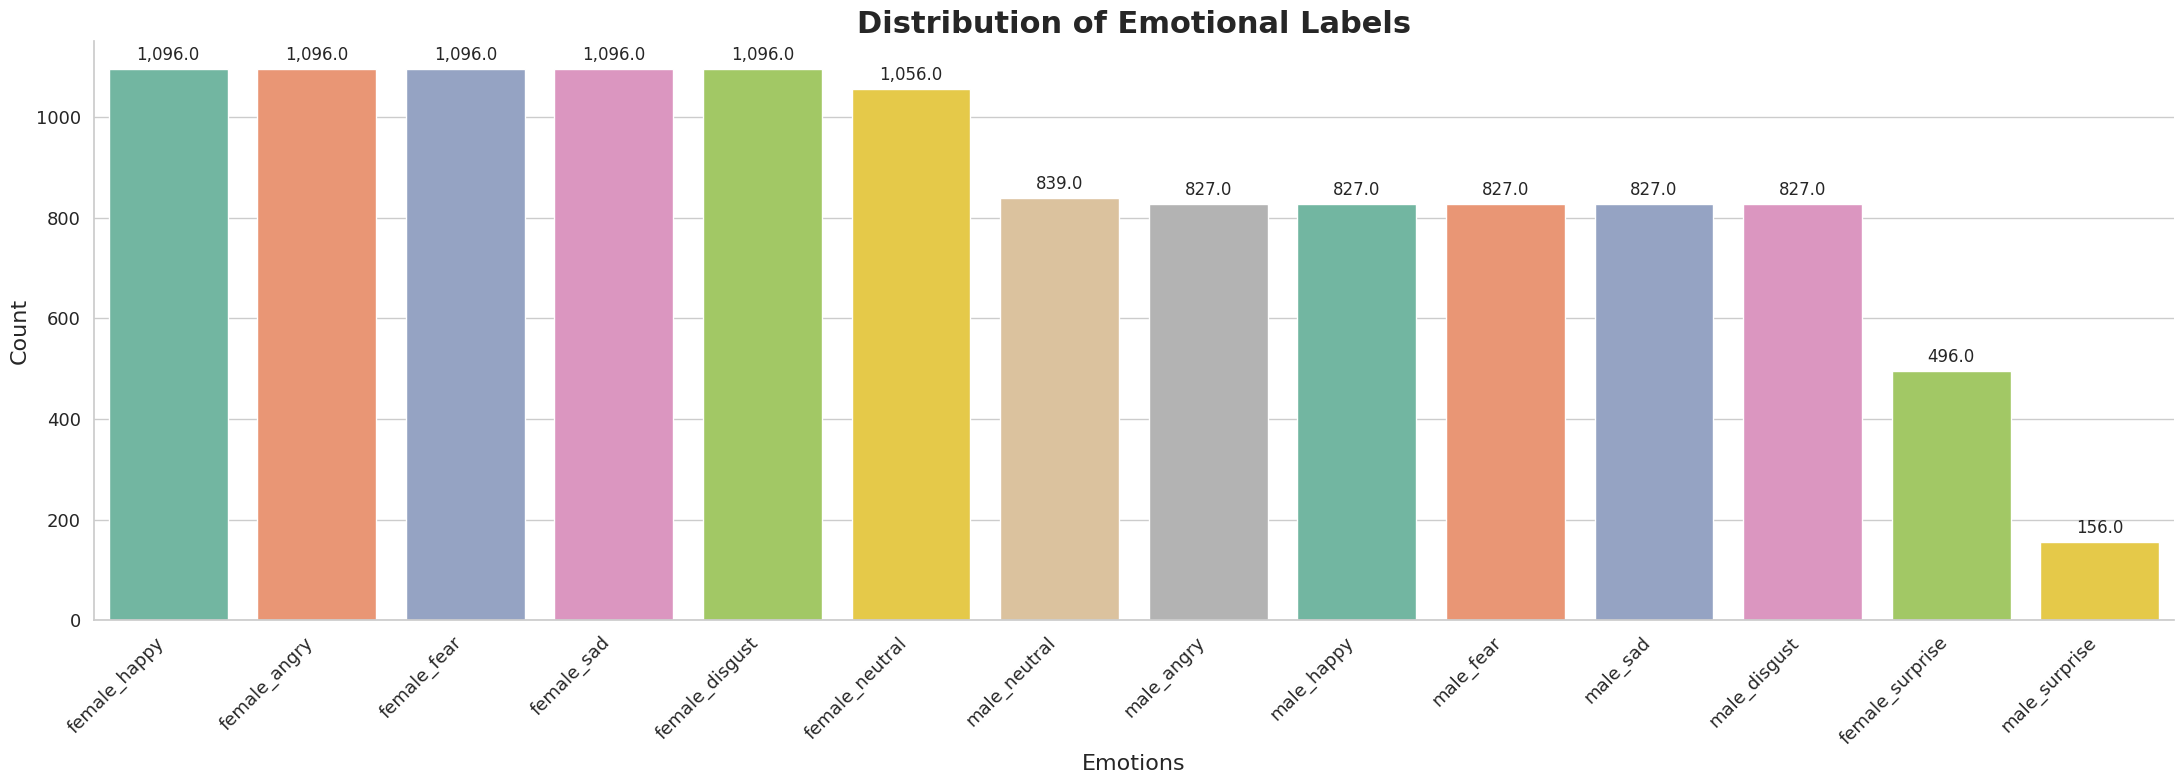

In [ ]:
plt.figure(figsize=(22, 8))

# Sort labels by count (optional, but often more informative)
order = data_path['labels'].value_counts().index

# Use a color palette and improve layout
sns.countplot(x='labels', data=data_path, order=order, palette='Set2')

# Set text sizes and labels
plt.ylabel('Count', fontsize=16)
plt.xlabel('Emotions', fontsize=16)
plt.title('Distribution of Emotional Labels', fontsize=22, fontweight='bold')

# Rotate x-ticks if labels are long
plt.xticks(rotation=45, ha='right', fontsize=13)
plt.yticks(fontsize=13)

# Remove top/right spines
sns.despine(top=True, right=True)

# Add bar values (counts) on top of each bar
for p in plt.gca().patches:
    plt.gca().annotate(
        format(p.get_height(), ','),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 10), textcoords='offset points',
        fontsize=12
    )

plt.tight_layout()
plt.show()


/tmp/ipython-input-28-2149513895.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data_path, x='emotion', order=order, palette='Set2')


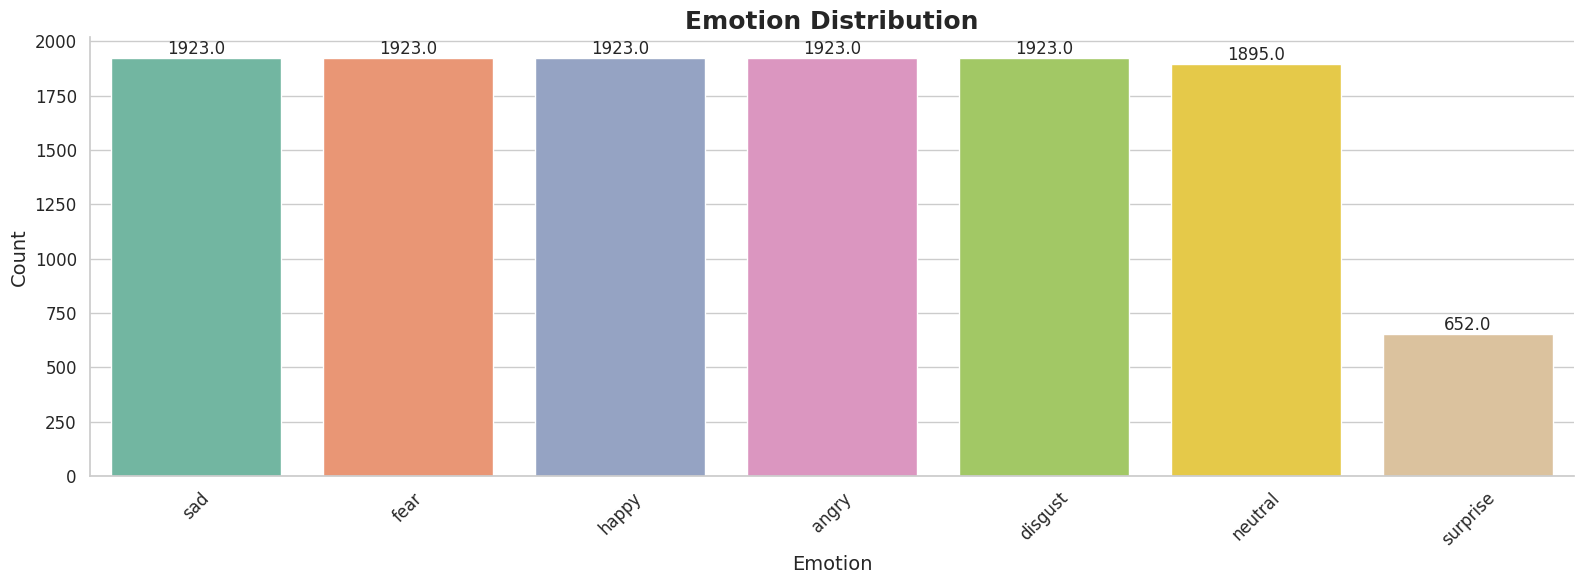

In [ ]:
plt.figure(figsize=(16, 6))
order = data_path['emotion'].value_counts().index
ax = sns.countplot(data=data_path, x='emotion', order=order, palette='Set2')

# Add bar labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12)

plt.title('Emotion Distribution', fontsize=18, fontweight='bold')
plt.xlabel('Emotion', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()


/tmp/ipython-input-29-1298596761.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=data_path, x='gender', palette='coolwarm')


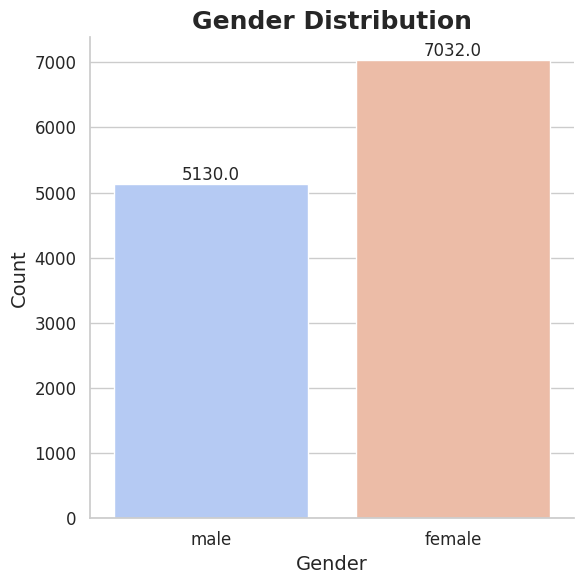

In [ ]:
plt.figure(figsize=(6, 6))
ax = sns.countplot(data=data_path, x='gender', palette='coolwarm')

# Add bar labels
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=12)

plt.title('Gender Distribution', fontsize=18, fontweight='bold')
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()


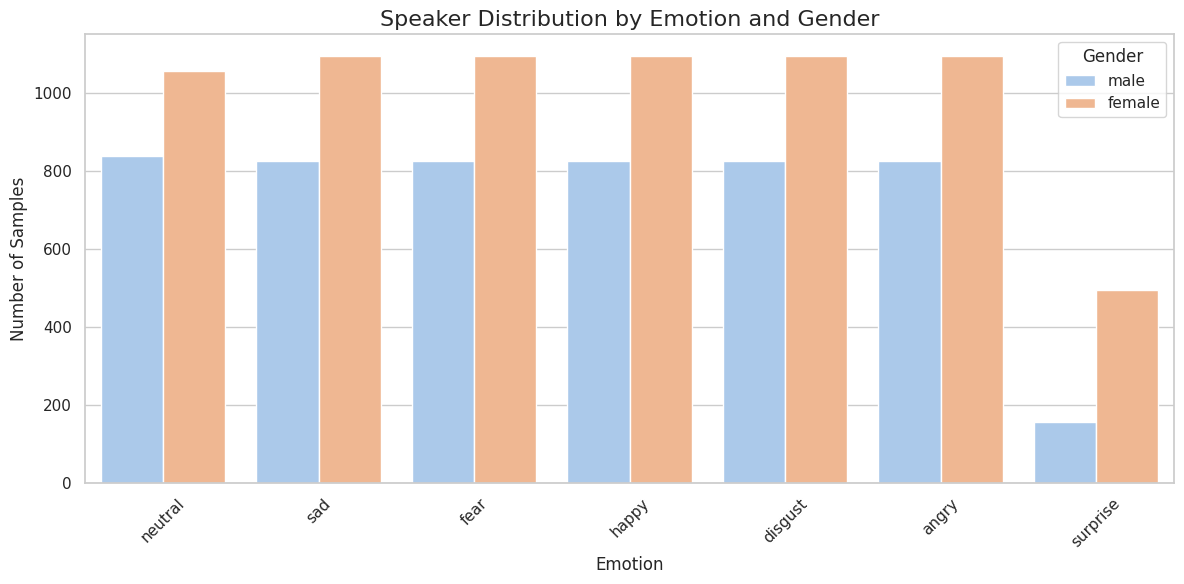

In [ ]:
sns.set(style="whitegrid")

# Plot: Histogram of emotion counts grouped by gender
plt.figure(figsize=(12, 6))
sns.countplot(data=data_path, x='emotion', hue='gender', palette='pastel')

plt.title('Speaker Distribution by Emotion and Gender', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

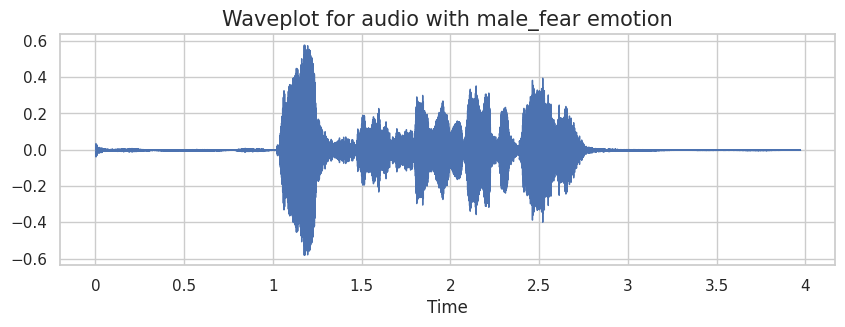

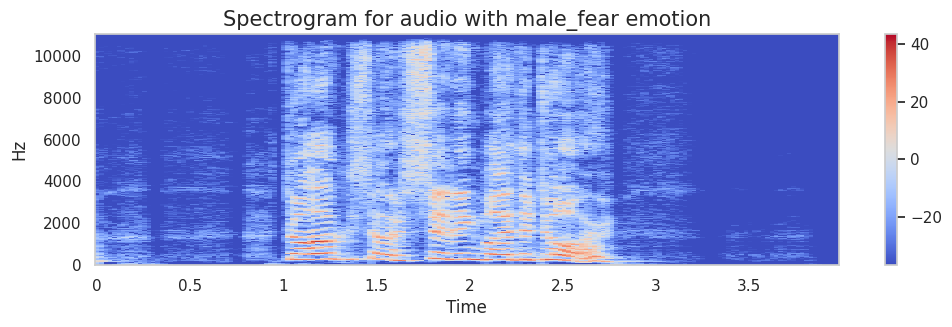

In [ ]:
emotion='male_fear'
path = np.array(data_path.path[data_path.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

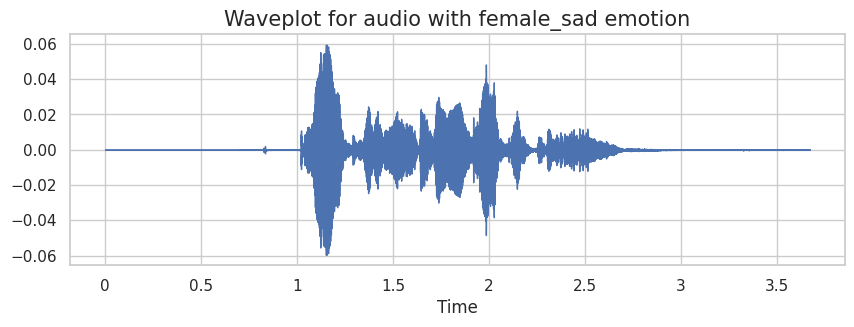

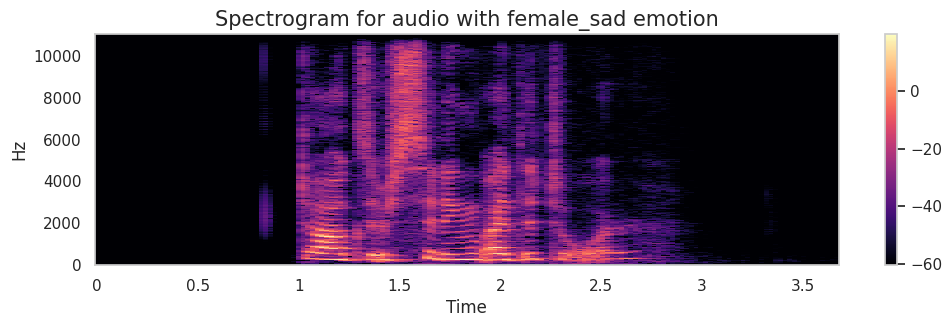

In [ ]:
emotion='female_sad'
path = np.array(data_path.path[data_path.labels==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Feature Extraction & Augmentation

In [ ]:
label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["labels"])

In [ ]:
class AudioDataset(Dataset):
    def __init__(self, dataframe, label_encoder):
        self.df = dataframe
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.iloc[idx]["path"]
        label = self.df.iloc[idx]["label_id"]

        waveform, sr = load_audio(path)
        features = extract_features(waveform, sr)

        return torch.tensor(features, dtype=torch.float32), label


In [ ]:
dataset = AudioDataset(df, label_encoder)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SAMPLE_RATE = 22050

def load_audio(path, duration=3.0, offset=0.5, sample_rate=SAMPLE_RATE):
    waveform, sr = torchaudio.load(path)
    waveform = waveform.to(device)

    # Convert to mono
    if waveform.shape[0] > 1:
        waveform = waveform.mean(dim=0, keepdim=True)

    # Resample if needed
    if sr != sample_rate:
        resampler = T.Resample(orig_freq=sr, new_freq=sample_rate).to(device)
        waveform = resampler(waveform)
        sr = sample_rate

    # Offset and trim
    offset_samples = int(offset * sr)
    num_samples = int(duration * sr)
    waveform = waveform[:, offset_samples:offset_samples + num_samples]

    return waveform, sr

### Augmentations

In [ ]:
def add_noise(waveform, noise_level=0.005):
    noise = torch.randn_like(waveform).to(device) * noise_level
    return waveform + noise

def time_shift(waveform, shift_ratio=0.2):
    shift_amt = int(waveform.shape[1] * shift_ratio)
    return torch.roll(waveform, shifts=shift_amt, dims=1)

def pitch_shift(waveform, sr, n_steps=2):
    return torchaudio.functional.pitch_shift(waveform, sample_rate=sr, n_steps=n_steps)

def change_speed(waveform, rate):
    new_sr = int(SAMPLE_RATE * rate)
    return torchaudio.functional.resample(waveform, orig_freq=SAMPLE_RATE, new_freq=new_sr)


### Features Extraction

In [ ]:
def extract_features(waveform, sr=SAMPLE_RATE):
    # Apply transforms directly on GPU
    features = []

    mfcc = T.MFCC(sample_rate=sr, n_mfcc=40).to(device)(waveform)
    features.append(mfcc.mean(dim=-1).squeeze())

    mel = T.MelSpectrogram(sample_rate=sr).to(device)(waveform)
    mel_db = T.AmplitudeToDB().to(device)(mel)
    features.append(mel_db.mean(dim=-1).squeeze())

    rms = waveform.pow(2).mean(dim=-1, keepdim=True).sqrt()
    features.append(rms.mean().unsqueeze(0))

    zcr = waveform.sign().diff(dim=-1).abs().sum(dim=-1)
    features.append(zcr.mean().unsqueeze(0))

    return torch.cat(features).detach()

### All augmentations

In [ ]:
def get_features(path):
    waveform, sr = load_audio(path)

    # Augmented versions
    versions = [
        waveform,
        add_noise(waveform),
        time_shift(waveform),
        pitch_shift(waveform, sr, n_steps=2),
        change_speed(waveform, 1.25),
        change_speed(waveform, 0.8),
    ]

    features = [extract_features(w, sr).cpu().numpy() for w in versions]
    return np.array(features)

### Extracting features

In [ ]:
X, Y = [], []

for path, emotion in tqdm(zip(data_path.path, data_path.labels), total=len(data_path), desc="Extracting features"):
    features = get_features(path)
    for feature in features:
        X.append(feature)
        Y.append(emotion)


Extracting features:   0%|          | 0/12162 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
Extracting features: 100%|██████████| 12162/12162 [1:08:00<00:00,  2.98it/s]


In [ ]:
len(X), len(Y), data_path.path.shape

(72972, 72972, (12162,))

### Save for later use

In [ ]:
features = pd.DataFrame(X)
features['labels'] = Y
features.to_csv('Features.csv', index=False)
print(len(features))
features.head()

72972


,0,1,2,3,4,5,6,7,8,9,...,161,162,163,164,165,166,167,168,169,labels
0,-671.621277,45.660480,-12.469194,-8.212440,-7.143340,-12.474537,-11.206752,-8.688819,-6.216384,-2.813773,...,-66.883286,-66.574112,-67.250191,-67.463715,-67.471352,-67.505806,-68.616211,0.004871,21234.0,male_neutral
1,-300.744324,-70.259026,-26.926096,-30.555126,-23.339239,-20.890528,-14.047930,-9.717221,-4.120385,-1.623624,...,-18.814400,-18.983023,-18.557089,-18.439964,-18.414822,-18.365772,-18.444180,0.006973,54042.0,male_neutral
2,-675.246826,44.905521,-12.079396,-8.454112,-7.146355,-12.336256,-11.118939,-8.652890,-6.245615,-2.757731,...,-66.931206,-66.660187,-67.339294,-67.470490,-67.434830,-67.435333,-68.627930,0.004871,21234.0,male_neutral
3,-700.488892,45.976913,-15.632800,-5.502389,-12.082150,-13.351903,-14.431161,-7.470426,-7.103704,3.222632,...,-74.799576,-73.414261,-73.016396,-72.536316,-72.191261,-72.598488,-72.690323,0.003564,25868.0,male_neutral
4,-684.699158,57.176788,-17.424713,-0.689692,-11.951156,0.160138,-14.491299,-1.992193,-9.065502,-2.655769,...,-77.063072,-78.832123,-80.619781,-82.457886,-85.282219,-88.474716,-93.059082,0.004871,26096.0,male_neutral


# Data preparation

In [ ]:
# Load data from CSV
features = pd.read_csv('Features.csv')

# Drop rows with missing labels
features.dropna(subset=['labels'], inplace=True)

# Separate features and full labels
X = features.iloc[:, :-1].values
Y = features['labels'].values

# --------------------- ORIGINAL FULL LABEL ENCODING (e.g., male_angry) ---------------------
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)  # 14 or 16 unique classes depending on dataset

# --------------------- EMOTION-ONLY LABEL ENCODING ---------------------
# Remove gender prefix to isolate emotion
emotion_labels = [label.split('_')[1] for label in Y]

emotion_label_encoder = LabelEncoder()
Y_emotion_encoded = emotion_label_encoder.fit_transform(emotion_labels)  # 7 emotion classes

# --------------------- TRAIN-TEST SPLIT (Shared) ---------------------
x_train, x_test, y_train_full, y_test_full, y_train_emotion, y_test_emotion = train_test_split(
    X, Y_encoded, Y_emotion_encoded, test_size=0.2, random_state=42, shuffle=True
)

# --------------------- RESHAPE FEATURES FOR Conv1D ---------------------
x_train = x_train[:, :, None]  # Shape: (N, features, 1)
x_test = x_test[:, :, None]

# --------------------- CONVERT TO PyTorch TENSORS ---------------------
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_full, dtype=torch.long)  # full labels
y_test_tensor = torch.tensor(y_test_full, dtype=torch.long)

y_train_tensor_emotion = torch.tensor(y_train_emotion, dtype=torch.long)  # emotion-only labels
y_test_tensor_emotion = torch.tensor(y_test_emotion, dtype=torch.long)

# --------------------- DATASETS AND DATALOADERS ---------------------
# Full label dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Emotion-only dataloaders
emotion_train_dataset = TensorDataset(x_train_tensor, y_train_tensor_emotion)
emotion_test_dataset = TensorDataset(x_test_tensor, y_test_tensor_emotion)

emotion_train_loader = DataLoader(emotion_train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
emotion_test_loader = DataLoader(emotion_test_dataset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)


# Model

In [ ]:
class CNN_BiLSTM(nn.Module):
    def __init__(
        self,
        input_shape,
        num_classes,
        num_cnn_layers=4,
        num_lstm_layers=1,
        lstm_units=256,
        cnn_filters=128,
        kernel_size=3,
        use_batch_norm=False,
        l2_reg=1e-5
    ):
        super(CNN_BiLSTM, self).__init__()

        self.use_batch_norm = use_batch_norm
        self.cnn_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()

        in_channels = input_shape[1]  # input_shape = (seq_len, channels)
        for _ in range(num_cnn_layers):
            conv = nn.Conv1d(
                in_channels=in_channels,
                out_channels=cnn_filters,
                kernel_size=kernel_size,
                padding=kernel_size // 2
            )
            self.cnn_layers.append(conv)
            if use_batch_norm:
                self.bn_layers.append(nn.BatchNorm1d(cnn_filters))
            in_channels = cnn_filters

        self.dropout = nn.Dropout(0.3)

        self.lstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_units,
            num_layers=num_lstm_layers,
            batch_first=True,
            bidirectional=True
        )

        self.fc = nn.Linear(lstm_units * 2, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, 1) → reshape to (batch, channels, seq_len)
        x = x.permute(0, 2, 1)

        for i, conv in enumerate(self.cnn_layers):
            x = conv(x)
            x = F.relu(x)
            if self.use_batch_norm:
                x = self.bn_layers[i](x)
            x = self.dropout(x)

        # Back to (batch, seq_len, channels) for LSTM
        x = x.permute(0, 2, 1)

        # LSTM
        lstm_out, _ = self.lstm(x)
        # Use last time step output
        x = lstm_out[:, -1, :]

        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device,
                epochs=100, patience=5, model_path='best_model.pt'):

    best_val_acc = 0
    counter = 0

    # History for plots
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)
        for batch_x, batch_y in train_loader_tqdm:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == batch_y).sum().item()
            total += batch_y.size(0)

            train_loader_tqdm.set_postfix(
                loss=running_loss / (total / batch_y.size(0)),
                acc=correct / total
            )

        train_acc = correct / total
        avg_loss = running_loss / len(train_loader)

        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)
            for val_x, val_y in val_loader_tqdm:
                val_x, val_y = val_x.to(device), val_y.to(device)
                val_outputs = model(val_x)
                val_preds = val_outputs.argmax(dim=1)
                val_correct += (val_preds == val_y).sum().item()
                val_total += val_y.size(0)

        val_acc = val_correct / val_total
        val_accuracies.append(val_acc)

        scheduler.step(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            counter = 0
            torch.save(model.state_dict(), model_path)
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    print(f"Best Validation Accuracy: {best_val_acc:.4f}")

    # Return history
    return {
        'train_loss': train_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    }


## Training emotion model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model
emotion_model = CNN_BiLSTM(
    input_shape=(x_train_tensor.shape[1], x_train_tensor.shape[2]),
    num_classes=len(set(y_train_tensor_emotion.tolist())),
    use_batch_norm=True
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(emotion_model.parameters(), lr=0.0015)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
history = train_model(
    model=emotion_model,
    train_loader=emotion_train_loader,
    val_loader=emotion_test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=300,
    patience=5
)


Epoch 1/300 - Loss: 1.7703, Train Acc: 0.2717, Val Acc: 0.3153


Epoch 2/300 - Loss: 1.7069, Train Acc: 0.3080, Val Acc: 0.3383


Epoch 3/300 - Loss: 1.6662, Train Acc: 0.3262, Val Acc: 0.3592


Epoch 4/300 - Loss: 1.6195, Train Acc: 0.3453, Val Acc: 0.3847


Epoch 5/300 - Loss: 1.5762, Train Acc: 0.3563, Val Acc: 0.4006


Epoch 6/300 - Loss: 1.5195, Train Acc: 0.3855, Val Acc: 0.4353


Epoch 7/300 - Loss: 1.4679, Train Acc: 0.4084, Val Acc: 0.4562


Epoch 8/300 - Loss: 1.4283, Train Acc: 0.4221, Val Acc: 0.4607


Epoch 9/300 - Loss: 1.4006, Train Acc: 0.4330, Val Acc: 0.4867


Epoch 10/300 - Loss: 1.3678, Train Acc: 0.4499, Val Acc: 0.4910


Epoch 11/300 - Loss: 1.3488, Train Acc: 0.4599, Val Acc: 0.4978


Epoch 12/300 - Loss: 1.3226, Train Acc: 0.4688, Val Acc: 0.4987


Epoch 13/300 - Loss: 1.3128, Train Acc: 0.4747, Val Acc: 0.5048


Epoch 14/300 - Loss: 1.2956, Train Acc: 0.4791, Val Acc: 0.5197


Epoch 15/300 - Loss: 1.2770, Train Acc: 0.4871, Val Acc: 0.5227


Epoch 16/300 - Loss: 1.2692, Train Acc: 0.4913, Val Acc: 0.5300


Epoch 17/300 - Loss: 1.2572, Train Acc: 0.4983, Val Acc: 0.5198


Epoch 18/300 - Loss: 1.2442, Train Acc: 0.5003, Val Acc: 0.5222


Epoch 19/300 - Loss: 1.2347, Train Acc: 0.5059, Val Acc: 0.5424


Epoch 20/300 - Loss: 1.2221, Train Acc: 0.5087, Val Acc: 0.5344


Epoch 21/300 - Loss: 1.2155, Train Acc: 0.5132, Val Acc: 0.5349


Epoch 22/300 - Loss: 1.2115, Train Acc: 0.5142, Val Acc: 0.5444


Epoch 23/300 - Loss: 1.2055, Train Acc: 0.5168, Val Acc: 0.5456


Epoch 24/300 - Loss: 1.1986, Train Acc: 0.5200, Val Acc: 0.5454


Epoch 25/300 - Loss: 1.1936, Train Acc: 0.5215, Val Acc: 0.5553


Epoch 26/300 - Loss: 1.1803, Train Acc: 0.5264, Val Acc: 0.5517


Epoch 27/300 - Loss: 1.1828, Train Acc: 0.5279, Val Acc: 0.5546


Epoch 28/300 - Loss: 1.1735, Train Acc: 0.5319, Val Acc: 0.5626


Epoch 29/300 - Loss: 1.1713, Train Acc: 0.5306, Val Acc: 0.5566


Epoch 30/300 - Loss: 1.1653, Train Acc: 0.5339, Val Acc: 0.5581


Epoch 31/300 - Loss: 1.1534, Train Acc: 0.5393, Val Acc: 0.5649


Epoch 32/300 - Loss: 1.1551, Train Acc: 0.5385, Val Acc: 0.5632


Epoch 33/300 - Loss: 1.1503, Train Acc: 0.5407, Val Acc: 0.5758


Epoch 34/300 - Loss: 1.1477, Train Acc: 0.5404, Val Acc: 0.5694


Epoch 35/300 - Loss: 1.1364, Train Acc: 0.5452, Val Acc: 0.5728


Epoch 36/300 - Loss: 1.1363, Train Acc: 0.5460, Val Acc: 0.5693


Epoch 37/300 - Loss: 1.1306, Train Acc: 0.5472, Val Acc: 0.5784


Epoch 38/300 - Loss: 1.1253, Train Acc: 0.5495, Val Acc: 0.5753


Epoch 39/300 - Loss: 1.1248, Train Acc: 0.5496, Val Acc: 0.5768


Epoch 40/300 - Loss: 1.1247, Train Acc: 0.5502, Val Acc: 0.5710


Epoch 41/300 - Loss: 1.1174, Train Acc: 0.5547, Val Acc: 0.5747


Epoch 42/300 - Loss: 1.0785, Train Acc: 0.5681, Val Acc: 0.5927


Epoch 43/300 - Loss: 1.0641, Train Acc: 0.5735, Val Acc: 0.5936


Epoch 44/300 - Loss: 1.0585, Train Acc: 0.5762, Val Acc: 0.5993


Epoch 45/300 - Loss: 1.0561, Train Acc: 0.5761, Val Acc: 0.5964


Epoch 46/300 - Loss: 1.0488, Train Acc: 0.5806, Val Acc: 0.6010


Epoch 47/300 - Loss: 1.0430, Train Acc: 0.5837, Val Acc: 0.6055


Epoch 48/300 - Loss: 1.0420, Train Acc: 0.5843, Val Acc: 0.6012


Epoch 49/300 - Loss: 1.0396, Train Acc: 0.5850, Val Acc: 0.6099


Epoch 50/300 - Loss: 1.0355, Train Acc: 0.5848, Val Acc: 0.6062


Epoch 51/300 - Loss: 1.0317, Train Acc: 0.5875, Val Acc: 0.6060


Epoch 52/300 - Loss: 1.0231, Train Acc: 0.5922, Val Acc: 0.6056


Epoch 53/300 - Loss: 1.0258, Train Acc: 0.5906, Val Acc: 0.6147


Epoch 54/300 - Loss: 1.0198, Train Acc: 0.5933, Val Acc: 0.6125


Epoch 55/300 - Loss: 1.0144, Train Acc: 0.5955, Val Acc: 0.6112


Epoch 56/300 - Loss: 1.0127, Train Acc: 0.5941, Val Acc: 0.6132


Epoch 57/300 - Loss: 1.0095, Train Acc: 0.5985, Val Acc: 0.6165


Epoch 58/300 - Loss: 1.0056, Train Acc: 0.5981, Val Acc: 0.6132


Epoch 59/300 - Loss: 1.0066, Train Acc: 0.5990, Val Acc: 0.6134


Epoch 60/300 - Loss: 0.9997, Train Acc: 0.6018, Val Acc: 0.6135


Epoch 61/300 - Loss: 0.9970, Train Acc: 0.6018, Val Acc: 0.6169


Epoch 62/300 - Loss: 0.9932, Train Acc: 0.6042, Val Acc: 0.6212


Epoch 63/300 - Loss: 0.9912, Train Acc: 0.6057, Val Acc: 0.6268


Epoch 64/300 - Loss: 0.9893, Train Acc: 0.6062, Val Acc: 0.6234


Epoch 65/300 - Loss: 0.9859, Train Acc: 0.6082, Val Acc: 0.6184


Epoch 66/300 - Loss: 0.9837, Train Acc: 0.6108, Val Acc: 0.6280


Epoch 67/300 - Loss: 0.9782, Train Acc: 0.6109, Val Acc: 0.6234


Epoch 68/300 - Loss: 0.9722, Train Acc: 0.6131, Val Acc: 0.6254


Epoch 69/300 - Loss: 0.9709, Train Acc: 0.6146, Val Acc: 0.6291


Epoch 70/300 - Loss: 0.9710, Train Acc: 0.6129, Val Acc: 0.6281


Epoch 71/300 - Loss: 0.9688, Train Acc: 0.6167, Val Acc: 0.6271


Epoch 72/300 - Loss: 0.9629, Train Acc: 0.6187, Val Acc: 0.6315


Epoch 73/300 - Loss: 0.9629, Train Acc: 0.6188, Val Acc: 0.6288


Epoch 74/300 - Loss: 0.9611, Train Acc: 0.6158, Val Acc: 0.6291


Epoch 75/300 - Loss: 0.9563, Train Acc: 0.6204, Val Acc: 0.6245


Epoch 76/300 - Loss: 0.9526, Train Acc: 0.6221, Val Acc: 0.6293


Epoch 77/300 - Loss: 0.9320, Train Acc: 0.6297, Val Acc: 0.6413


Epoch 78/300 - Loss: 0.9211, Train Acc: 0.6360, Val Acc: 0.6408


Epoch 79/300 - Loss: 0.9187, Train Acc: 0.6354, Val Acc: 0.6439


Epoch 80/300 - Loss: 0.9136, Train Acc: 0.6385, Val Acc: 0.6444


Epoch 81/300 - Loss: 0.9085, Train Acc: 0.6415, Val Acc: 0.6450


Epoch 82/300 - Loss: 0.9105, Train Acc: 0.6385, Val Acc: 0.6491


Epoch 83/300 - Loss: 0.9053, Train Acc: 0.6411, Val Acc: 0.6458


Epoch 84/300 - Loss: 0.9023, Train Acc: 0.6424, Val Acc: 0.6480


Epoch 85/300 - Loss: 0.9012, Train Acc: 0.6407, Val Acc: 0.6499


Epoch 86/300 - Loss: 0.8967, Train Acc: 0.6451, Val Acc: 0.6498


Epoch 87/300 - Loss: 0.8974, Train Acc: 0.6451, Val Acc: 0.6522


Epoch 88/300 - Loss: 0.8945, Train Acc: 0.6464, Val Acc: 0.6556


Epoch 89/300 - Loss: 0.8933, Train Acc: 0.6457, Val Acc: 0.6525


Epoch 90/300 - Loss: 0.8921, Train Acc: 0.6465, Val Acc: 0.6539


Epoch 91/300 - Loss: 0.8871, Train Acc: 0.6482, Val Acc: 0.6565


Epoch 92/300 - Loss: 0.8864, Train Acc: 0.6486, Val Acc: 0.6510


Epoch 93/300 - Loss: 0.8803, Train Acc: 0.6538, Val Acc: 0.6550


Epoch 94/300 - Loss: 0.8785, Train Acc: 0.6526, Val Acc: 0.6577


Epoch 95/300 - Loss: 0.8760, Train Acc: 0.6541, Val Acc: 0.6560


Epoch 96/300 - Loss: 0.8751, Train Acc: 0.6564, Val Acc: 0.6588


Epoch 97/300 - Loss: 0.8695, Train Acc: 0.6574, Val Acc: 0.6554


Epoch 98/300 - Loss: 0.8704, Train Acc: 0.6560, Val Acc: 0.6563


Epoch 99/300 - Loss: 0.8621, Train Acc: 0.6600, Val Acc: 0.6608


Epoch 100/300 - Loss: 0.8644, Train Acc: 0.6583, Val Acc: 0.6662


Epoch 101/300 - Loss: 0.8649, Train Acc: 0.6595, Val Acc: 0.6602


Epoch 102/300 - Loss: 0.8571, Train Acc: 0.6612, Val Acc: 0.6658


Epoch 103/300 - Loss: 0.8541, Train Acc: 0.6619, Val Acc: 0.6599


Epoch 104/300 - Loss: 0.8612, Train Acc: 0.6610, Val Acc: 0.6661


Epoch 105/300 - Loss: 0.8427, Train Acc: 0.6673, Val Acc: 0.6677


Epoch 106/300 - Loss: 0.8386, Train Acc: 0.6703, Val Acc: 0.6687


Epoch 107/300 - Loss: 0.8356, Train Acc: 0.6706, Val Acc: 0.6718


Epoch 108/300 - Loss: 0.8300, Train Acc: 0.6724, Val Acc: 0.6681


Epoch 109/300 - Loss: 0.8294, Train Acc: 0.6730, Val Acc: 0.6727


Epoch 110/300 - Loss: 0.8277, Train Acc: 0.6739, Val Acc: 0.6667


Epoch 111/300 - Loss: 0.8264, Train Acc: 0.6743, Val Acc: 0.6734


Epoch 112/300 - Loss: 0.8238, Train Acc: 0.6760, Val Acc: 0.6740


Epoch 113/300 - Loss: 0.8216, Train Acc: 0.6762, Val Acc: 0.6726


Epoch 114/300 - Loss: 0.8242, Train Acc: 0.6765, Val Acc: 0.6756


Epoch 115/300 - Loss: 0.8178, Train Acc: 0.6782, Val Acc: 0.6743


Epoch 116/300 - Loss: 0.8160, Train Acc: 0.6780, Val Acc: 0.6763


Epoch 117/300 - Loss: 0.8175, Train Acc: 0.6794, Val Acc: 0.6760


Epoch 118/300 - Loss: 0.8132, Train Acc: 0.6787, Val Acc: 0.6795


Epoch 119/300 - Loss: 0.8150, Train Acc: 0.6802, Val Acc: 0.6802


Epoch 120/300 - Loss: 0.8097, Train Acc: 0.6811, Val Acc: 0.6802


Epoch 121/300 - Loss: 0.8079, Train Acc: 0.6826, Val Acc: 0.6787


Epoch 122/300 - Loss: 0.8114, Train Acc: 0.6815, Val Acc: 0.6811


Epoch 123/300 - Loss: 0.8059, Train Acc: 0.6835, Val Acc: 0.6759


Epoch 124/300 - Loss: 0.8073, Train Acc: 0.6815, Val Acc: 0.6773


Epoch 125/300 - Loss: 0.8074, Train Acc: 0.6844, Val Acc: 0.6782


Epoch 126/300 - Loss: 0.8078, Train Acc: 0.6826, Val Acc: 0.6790


Epoch 127/300 - Loss: 0.7946, Train Acc: 0.6855, Val Acc: 0.6819


Epoch 128/300 - Loss: 0.7920, Train Acc: 0.6890, Val Acc: 0.6828


Epoch 129/300 - Loss: 0.7918, Train Acc: 0.6910, Val Acc: 0.6824


Epoch 130/300 - Loss: 0.7865, Train Acc: 0.6894, Val Acc: 0.6854


Epoch 131/300 - Loss: 0.7859, Train Acc: 0.6916, Val Acc: 0.6874


Epoch 132/300 - Loss: 0.7847, Train Acc: 0.6921, Val Acc: 0.6854


Epoch 133/300 - Loss: 0.7835, Train Acc: 0.6937, Val Acc: 0.6871


Epoch 134/300 - Loss: 0.7845, Train Acc: 0.6925, Val Acc: 0.6849


Epoch 135/300 - Loss: 0.7839, Train Acc: 0.6922, Val Acc: 0.6869


Epoch 136/300 - Loss: 0.7781, Train Acc: 0.6949, Val Acc: 0.6872
Early stopping triggered.
Best Validation Accuracy: 0.6874


## Training original model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define model
original_model = CNN_BiLSTM(
    input_shape=(x_train_tensor.shape[1], x_train_tensor.shape[2]),
    num_classes=len(set(y_train_tensor.tolist())),
    use_batch_norm=True
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(original_model.parameters(), lr=0.0015)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

In [ ]:
history = train_model(
    model=original_model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    epochs=300,
    patience=5
)

Epoch 1/500 - Loss: 4349.9196, Train Acc: 0.1648, Val Acc: 0.2096


Epoch 2/500 - Loss: 4096.2319, Train Acc: 0.2069, Val Acc: 0.2460


Epoch 3/500 - Loss: 3945.0262, Train Acc: 0.2365, Val Acc: 0.2692


Epoch 4/500 - Loss: 3821.1129, Train Acc: 0.2558, Val Acc: 0.3034


Epoch 5/500 - Loss: 3659.7539, Train Acc: 0.2932, Val Acc: 0.3453


Epoch 6/500 - Loss: 3558.5191, Train Acc: 0.3152, Val Acc: 0.3674


Epoch 7/500 - Loss: 3402.3987, Train Acc: 0.3476, Val Acc: 0.4009


Epoch 8/500 - Loss: 3298.3000, Train Acc: 0.3641, Val Acc: 0.4138


Epoch 9/500 - Loss: 3197.5734, Train Acc: 0.3819, Val Acc: 0.4232


Epoch 10/500 - Loss: 3135.5425, Train Acc: 0.3924, Val Acc: 0.4468


Epoch 11/500 - Loss: 3066.7143, Train Acc: 0.4043, Val Acc: 0.4533


Epoch 12/500 - Loss: 2990.5848, Train Acc: 0.4195, Val Acc: 0.4669


Epoch 13/500 - Loss: 2905.5761, Train Acc: 0.4328, Val Acc: 0.4817


Epoch 14/500 - Loss: 2850.7686, Train Acc: 0.4412, Val Acc: 0.4882


Epoch 15/500 - Loss: 2809.2255, Train Acc: 0.4487, Val Acc: 0.4905


Epoch 16/500 - Loss: 2757.8904, Train Acc: 0.4597, Val Acc: 0.5035


Epoch 17/500 - Loss: 2706.9960, Train Acc: 0.4676, Val Acc: 0.4972


Epoch 18/500 - Loss: 2689.8976, Train Acc: 0.4715, Val Acc: 0.5065


Epoch 19/500 - Loss: 2653.9296, Train Acc: 0.4768, Val Acc: 0.5127


Epoch 20/500 - Loss: 2599.5315, Train Acc: 0.4870, Val Acc: 0.5181


Epoch 21/500 - Loss: 2580.7852, Train Acc: 0.4908, Val Acc: 0.5295


Epoch 22/500 - Loss: 2552.4790, Train Acc: 0.4980, Val Acc: 0.5285


Epoch 23/500 - Loss: 2518.6881, Train Acc: 0.5015, Val Acc: 0.5334


Epoch 24/500 - Loss: 2506.5065, Train Acc: 0.5055, Val Acc: 0.5442


Epoch 25/500 - Loss: 2462.7252, Train Acc: 0.5118, Val Acc: 0.5420


Epoch 26/500 - Loss: 2437.6475, Train Acc: 0.5179, Val Acc: 0.5448


Epoch 27/500 - Loss: 2416.7651, Train Acc: 0.5224, Val Acc: 0.5461


Epoch 28/500 - Loss: 2393.7632, Train Acc: 0.5252, Val Acc: 0.5570


Epoch 29/500 - Loss: 2372.5657, Train Acc: 0.5286, Val Acc: 0.5584


Epoch 30/500 - Loss: 2340.4727, Train Acc: 0.5354, Val Acc: 0.5516


Epoch 31/500 - Loss: 2318.4766, Train Acc: 0.5390, Val Acc: 0.5749


Epoch 32/500 - Loss: 2300.0786, Train Acc: 0.5403, Val Acc: 0.5762


Epoch 33/500 - Loss: 2273.4943, Train Acc: 0.5493, Val Acc: 0.5781


Epoch 34/500 - Loss: 2259.5560, Train Acc: 0.5492, Val Acc: 0.5768


Epoch 35/500 - Loss: 2235.4098, Train Acc: 0.5534, Val Acc: 0.5857


Epoch 36/500 - Loss: 2221.3789, Train Acc: 0.5585, Val Acc: 0.5829


Epoch 37/500 - Loss: 2188.7176, Train Acc: 0.5612, Val Acc: 0.5927


Epoch 38/500 - Loss: 2167.7350, Train Acc: 0.5651, Val Acc: 0.5940


Epoch 39/500 - Loss: 2165.0157, Train Acc: 0.5676, Val Acc: 0.5886


Epoch 40/500 - Loss: 2139.4851, Train Acc: 0.5714, Val Acc: 0.5933


Epoch 41/500 - Loss: 2120.9248, Train Acc: 0.5762, Val Acc: 0.5979


Epoch 42/500 - Loss: 2107.2858, Train Acc: 0.5769, Val Acc: 0.5960


Epoch 43/500 - Loss: 2078.1229, Train Acc: 0.5821, Val Acc: 0.6032


Epoch 44/500 - Loss: 2052.5787, Train Acc: 0.5892, Val Acc: 0.6073


Epoch 45/500 - Loss: 2035.2019, Train Acc: 0.5909, Val Acc: 0.6135


Epoch 46/500 - Loss: 2023.4049, Train Acc: 0.5915, Val Acc: 0.6200


Epoch 47/500 - Loss: 2003.9031, Train Acc: 0.5979, Val Acc: 0.6086


Epoch 48/500 - Loss: 1995.2154, Train Acc: 0.6003, Val Acc: 0.6253


Epoch 49/500 - Loss: 1987.4638, Train Acc: 0.5994, Val Acc: 0.6225


Epoch 50/500 - Loss: 1961.1842, Train Acc: 0.6058, Val Acc: 0.6256


Epoch 51/500 - Loss: 1947.5419, Train Acc: 0.6066, Val Acc: 0.6201


Epoch 52/500 - Loss: 1921.4894, Train Acc: 0.6136, Val Acc: 0.6320


Epoch 53/500 - Loss: 1905.7535, Train Acc: 0.6154, Val Acc: 0.6242


Epoch 54/500 - Loss: 1891.6648, Train Acc: 0.6170, Val Acc: 0.6402


Epoch 55/500 - Loss: 1881.3062, Train Acc: 0.6203, Val Acc: 0.6512


Epoch 56/500 - Loss: 1857.7802, Train Acc: 0.6232, Val Acc: 0.6425


Epoch 57/500 - Loss: 1844.2715, Train Acc: 0.6273, Val Acc: 0.6434


Epoch 58/500 - Loss: 1835.5386, Train Acc: 0.6292, Val Acc: 0.6426


Epoch 59/500 - Loss: 1815.9969, Train Acc: 0.6335, Val Acc: 0.6555


Epoch 60/500 - Loss: 1786.2336, Train Acc: 0.6374, Val Acc: 0.6466


Epoch 61/500 - Loss: 1776.0246, Train Acc: 0.6388, Val Acc: 0.6570


Epoch 62/500 - Loss: 1758.8851, Train Acc: 0.6447, Val Acc: 0.6581


Epoch 63/500 - Loss: 1757.8374, Train Acc: 0.6449, Val Acc: 0.6604


Epoch 64/500 - Loss: 1729.6253, Train Acc: 0.6494, Val Acc: 0.6680


Epoch 65/500 - Loss: 1716.8867, Train Acc: 0.6530, Val Acc: 0.6647


Epoch 66/500 - Loss: 1708.0856, Train Acc: 0.6542, Val Acc: 0.6603


Epoch 67/500 - Loss: 1688.9681, Train Acc: 0.6583, Val Acc: 0.6809


Epoch 68/500 - Loss: 1672.0395, Train Acc: 0.6618, Val Acc: 0.6758


Epoch 69/500 - Loss: 1662.1733, Train Acc: 0.6642, Val Acc: 0.6761


Epoch 70/500 - Loss: 1658.2523, Train Acc: 0.6635, Val Acc: 0.6707


Epoch 71/500 - Loss: 1630.1414, Train Acc: 0.6715, Val Acc: 0.6820


Epoch 72/500 - Loss: 1622.3368, Train Acc: 0.6715, Val Acc: 0.6889


Epoch 73/500 - Loss: 1608.8150, Train Acc: 0.6754, Val Acc: 0.6884


Epoch 74/500 - Loss: 1589.0677, Train Acc: 0.6782, Val Acc: 0.6799


Epoch 75/500 - Loss: 1586.1779, Train Acc: 0.6792, Val Acc: 0.6918


Epoch 76/500 - Loss: 1568.6858, Train Acc: 0.6838, Val Acc: 0.6820


Epoch 77/500 - Loss: 1559.0549, Train Acc: 0.6832, Val Acc: 0.6966


Epoch 78/500 - Loss: 1553.2447, Train Acc: 0.6858, Val Acc: 0.7001


Epoch 79/500 - Loss: 1532.5412, Train Acc: 0.6906, Val Acc: 0.7005


Epoch 80/500 - Loss: 1518.5487, Train Acc: 0.6922, Val Acc: 0.7076


Epoch 81/500 - Loss: 1509.7071, Train Acc: 0.6940, Val Acc: 0.6970


Epoch 82/500 - Loss: 1500.2518, Train Acc: 0.6961, Val Acc: 0.7045


Epoch 83/500 - Loss: 1486.9182, Train Acc: 0.7007, Val Acc: 0.7194


Epoch 84/500 - Loss: 1478.0922, Train Acc: 0.7013, Val Acc: 0.7173


Epoch 85/500 - Loss: 1464.1381, Train Acc: 0.7018, Val Acc: 0.7057


Epoch 86/500 - Loss: 1453.2346, Train Acc: 0.7072, Val Acc: 0.7059


Epoch 87/500 - Loss: 1439.2646, Train Acc: 0.7082, Val Acc: 0.7134


Epoch 88/500 - Loss: 1288.9333, Train Acc: 0.7379, Val Acc: 0.7473


Epoch 89/500 - Loss: 1243.6988, Train Acc: 0.7474, Val Acc: 0.7348


Epoch 90/500 - Loss: 1222.1671, Train Acc: 0.7527, Val Acc: 0.7387


Epoch 91/500 - Loss: 1203.3633, Train Acc: 0.7555, Val Acc: 0.7526


Epoch 92/500 - Loss: 1178.9440, Train Acc: 0.7603, Val Acc: 0.7535


Epoch 93/500 - Loss: 1175.8328, Train Acc: 0.7609, Val Acc: 0.7585


Epoch 94/500 - Loss: 1165.9246, Train Acc: 0.7630, Val Acc: 0.7603


Epoch 95/500 - Loss: 1149.3238, Train Acc: 0.7683, Val Acc: 0.7540


Epoch 96/500 - Loss: 1124.6839, Train Acc: 0.7706, Val Acc: 0.7730


Epoch 97/500 - Loss: 1122.3375, Train Acc: 0.7742, Val Acc: 0.7671


Epoch 98/500 - Loss: 1103.2841, Train Acc: 0.7768, Val Acc: 0.7685


Epoch 99/500 - Loss: 1097.2514, Train Acc: 0.7758, Val Acc: 0.7744


Epoch 100/500 - Loss: 1090.2041, Train Acc: 0.7793, Val Acc: 0.7751


Epoch 101/500 - Loss: 1079.3140, Train Acc: 0.7817, Val Acc: 0.7718


Epoch 102/500 - Loss: 1075.4100, Train Acc: 0.7845, Val Acc: 0.7726


Epoch 103/500 - Loss: 1058.9502, Train Acc: 0.7873, Val Acc: 0.7750


Epoch 104/500 - Loss: 1047.9486, Train Acc: 0.7885, Val Acc: 0.7828


Epoch 105/500 - Loss: 1040.9534, Train Acc: 0.7906, Val Acc: 0.7830


Epoch 106/500 - Loss: 1040.3051, Train Acc: 0.7904, Val Acc: 0.7870


Epoch 107/500 - Loss: 1020.3745, Train Acc: 0.7941, Val Acc: 0.7820


Epoch 108/500 - Loss: 1019.6210, Train Acc: 0.7943, Val Acc: 0.7800


Epoch 109/500 - Loss: 1015.8706, Train Acc: 0.7955, Val Acc: 0.7917


Epoch 110/500 - Loss: 989.9544, Train Acc: 0.8012, Val Acc: 0.7798


Epoch 111/500 - Loss: 988.6150, Train Acc: 0.8005, Val Acc: 0.7865


Epoch 112/500 - Loss: 986.7204, Train Acc: 0.8006, Val Acc: 0.7777


Epoch 113/500 - Loss: 967.1823, Train Acc: 0.8062, Val Acc: 0.8002


Epoch 114/500 - Loss: 984.0257, Train Acc: 0.8021, Val Acc: 0.7904


Epoch 115/500 - Loss: 962.9204, Train Acc: 0.8057, Val Acc: 0.7954


Epoch 116/500 - Loss: 956.4020, Train Acc: 0.8086, Val Acc: 0.7936


Epoch 117/500 - Loss: 956.3363, Train Acc: 0.8080, Val Acc: 0.8001


Epoch 118/500 - Loss: 868.6883, Train Acc: 0.8258, Val Acc: 0.8138


Epoch 119/500 - Loss: 836.2836, Train Acc: 0.8336, Val Acc: 0.8181


Epoch 120/500 - Loss: 832.0481, Train Acc: 0.8315, Val Acc: 0.8230


Epoch 121/500 - Loss: 816.4936, Train Acc: 0.8356, Val Acc: 0.8228


Epoch 122/500 - Loss: 809.7509, Train Acc: 0.8379, Val Acc: 0.8186


Epoch 123/500 - Loss: 804.2370, Train Acc: 0.8382, Val Acc: 0.8231


Epoch 124/500 - Loss: 800.3357, Train Acc: 0.8392, Val Acc: 0.8265


Epoch 125/500 - Loss: 795.3354, Train Acc: 0.8411, Val Acc: 0.8193


Epoch 126/500 - Loss: 797.8570, Train Acc: 0.8385, Val Acc: 0.8258


Epoch 127/500 - Loss: 770.3445, Train Acc: 0.8444, Val Acc: 0.8282


Epoch 128/500 - Loss: 769.1409, Train Acc: 0.8448, Val Acc: 0.8301


Epoch 129/500 - Loss: 785.1272, Train Acc: 0.8438, Val Acc: 0.8319


Epoch 130/500 - Loss: 773.6383, Train Acc: 0.8445, Val Acc: 0.8253


Epoch 131/500 - Loss: 764.4606, Train Acc: 0.8477, Val Acc: 0.8351


Epoch 132/500 - Loss: 750.4245, Train Acc: 0.8490, Val Acc: 0.8297


Epoch 133/500 - Loss: 743.8189, Train Acc: 0.8529, Val Acc: 0.8323


Epoch 134/500 - Loss: 748.5233, Train Acc: 0.8510, Val Acc: 0.8330


Epoch 135/500 - Loss: 737.8550, Train Acc: 0.8530, Val Acc: 0.8346


Epoch 136/500 - Loss: 701.8191, Train Acc: 0.8580, Val Acc: 0.8429


Epoch 137/500 - Loss: 688.2605, Train Acc: 0.8636, Val Acc: 0.8415


Epoch 138/500 - Loss: 684.5803, Train Acc: 0.8645, Val Acc: 0.8421


Epoch 139/500 - Loss: 680.2538, Train Acc: 0.8631, Val Acc: 0.8424


Epoch 140/500 - Loss: 673.7688, Train Acc: 0.8641, Val Acc: 0.8444


Epoch 141/500 - Loss: 676.8944, Train Acc: 0.8665, Val Acc: 0.8475


Epoch 142/500 - Loss: 666.4242, Train Acc: 0.8663, Val Acc: 0.8456


Epoch 143/500 - Loss: 667.7546, Train Acc: 0.8657, Val Acc: 0.8421


Epoch 144/500 - Loss: 658.0487, Train Acc: 0.8677, Val Acc: 0.8432


Epoch 145/500 - Loss: 663.2699, Train Acc: 0.8671, Val Acc: 0.8471


Epoch 146/500 - Loss: 641.7415, Train Acc: 0.8723, Val Acc: 0.8498


Epoch 147/500 - Loss: 630.2812, Train Acc: 0.8751, Val Acc: 0.8494


Epoch 148/500 - Loss: 636.8938, Train Acc: 0.8736, Val Acc: 0.8518


Epoch 149/500 - Loss: 637.2509, Train Acc: 0.8722, Val Acc: 0.8525


Epoch 150/500 - Loss: 630.9287, Train Acc: 0.8742, Val Acc: 0.8530


Epoch 151/500 - Loss: 630.5402, Train Acc: 0.8748, Val Acc: 0.8507


Epoch 152/500 - Loss: 626.3356, Train Acc: 0.8748, Val Acc: 0.8526


Epoch 153/500 - Loss: 625.9310, Train Acc: 0.8750, Val Acc: 0.8519


Epoch 154/500 - Loss: 622.4503, Train Acc: 0.8737, Val Acc: 0.8486


Epoch 155/500 - Loss: 616.4102, Train Acc: 0.8769, Val Acc: 0.8543


Epoch 156/500 - Loss: 606.6329, Train Acc: 0.8788, Val Acc: 0.8545


Epoch 157/500 - Loss: 612.8608, Train Acc: 0.8767, Val Acc: 0.8542


Epoch 158/500 - Loss: 601.9688, Train Acc: 0.8794, Val Acc: 0.8539


Epoch 159/500 - Loss: 604.2761, Train Acc: 0.8788, Val Acc: 0.8533


Epoch 160/500 - Loss: 607.4909, Train Acc: 0.8796, Val Acc: 0.8555


Epoch 161/500 - Loss: 606.2801, Train Acc: 0.8785, Val Acc: 0.8554


Epoch 162/500 - Loss: 611.3679, Train Acc: 0.8785, Val Acc: 0.8539


Epoch 163/500 - Loss: 597.2069, Train Acc: 0.8807, Val Acc: 0.8553


Epoch 164/500 - Loss: 601.5643, Train Acc: 0.8793, Val Acc: 0.8526


Epoch 165/500 - Loss: 609.6650, Train Acc: 0.8789, Val Acc: 0.8543
Early stopping triggered.


# Evaluation

In [ ]:
def evaluate_model_accuracy(model, test_loader, device):
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for test_x, test_y in test_loader:
            test_x, test_y = test_x.to(device), test_y.to(device)
            outputs = model(test_x)
            preds = outputs.argmax(dim=1)
            test_correct += (preds == test_y).sum().item()
            test_total += test_y.size(0)

    test_accuracy = test_correct / test_total
    print("Accuracy of our model on test data:", round(test_accuracy * 100, 2), "%")
    return test_accuracy


In [ ]:
def plot_training_history(train_loss, train_acc, val_acc):
    """
    Plots training loss and accuracy over epochs.

    Args:
        epochs (list or range): List of epoch numbers.
        train_loss (list): Training loss values.
        train_acc (list): Training accuracy values.
        val_acc (list): Validation accuracy values.
    """
    fig, ax = plt.subplots(1, 2, figsize=(20, 6))

    epochs = list(range(1, len(train_loss) + 1))

    # Loss plot
    ax[0].plot(epochs, train_loss, label='Training Loss', color='blue')
    ax[0].set_title('Training Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Accuracy plot
    ax[1].plot(epochs, train_acc, label='Training Accuracy', color='green')
    ax[1].plot(epochs, val_acc, label='Validation Accuracy', color='orange')
    ax[1].set_title('Training vs Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()

    plt.suptitle('Model Performance Over Epochs', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


## Emotion-only model

In [ ]:
emotion_model.load_state_dict(torch.load('/content/model_only_emotion_acc68.pt'))

<All keys matched successfully>

In [ ]:
emotion_accuracy = evaluate_model_accuracy(emotion_model, emotion_test_loader, device)

Accuracy of our model on test data: 68.74 %


In [ ]:
train_loss = [
    1.7703, 1.7069, 1.6662, 1.6195, 1.5762, 1.5195, 1.4679, 1.4283, 1.4006, 1.3678,
    1.3488, 1.3226, 1.3128, 1.2956, 1.2770, 1.2692, 1.2572, 1.2442, 1.2347, 1.2221,
    1.2155, 1.2115, 1.2055, 1.1986, 1.1936, 1.1803, 1.1828, 1.1735, 1.1713, 1.1653,
    1.1534, 1.1551, 1.1503, 1.1477, 1.1364, 1.1363, 1.1306, 1.1253, 1.1248, 1.1247,
    1.1174, 1.0785, 1.0641, 1.0585, 1.0561, 1.0488, 1.0430, 1.0420, 1.0396, 1.0355,
    1.0317, 1.0231, 1.0258, 1.0198, 1.0144, 1.0127, 1.0095, 1.0056, 1.0066, 0.9997,
    0.9970, 0.9932, 0.9912, 0.9893, 0.9859, 0.9837, 0.9782, 0.9722, 0.9709, 0.9710,
    0.9688, 0.9629, 0.9629, 0.9611, 0.9563, 0.9526, 0.9320, 0.9211, 0.9187, 0.9136,
    0.9085, 0.9105, 0.9053, 0.9023, 0.9012, 0.8967, 0.8974, 0.8945, 0.8933, 0.8921,
    0.8871, 0.8864, 0.8803, 0.8785, 0.8760, 0.8751, 0.8695, 0.8704, 0.8621, 0.8644,
    0.8649, 0.8571, 0.8541, 0.8612, 0.8427, 0.8386, 0.8356, 0.8300, 0.8294, 0.8277,
    0.8264, 0.8238, 0.8216, 0.8242, 0.8178, 0.8160, 0.8175, 0.8132, 0.8150, 0.8097,
    0.8079, 0.8114, 0.8059, 0.8073, 0.8074, 0.8078, 0.7946, 0.7920, 0.7918, 0.7865,
    0.7859, 0.7847, 0.7835, 0.7845, 0.7839, 0.7781
]

train_acc = [
    0.2717, 0.3080, 0.3262, 0.3453, 0.3563, 0.3855, 0.4084, 0.4221, 0.4330, 0.4499,
    0.4599, 0.4688, 0.4747, 0.4791, 0.4871, 0.4913, 0.4983, 0.5003, 0.5059, 0.5087,
    0.5132, 0.5142, 0.5168, 0.5200, 0.5215, 0.5264, 0.5279, 0.5319, 0.5306, 0.5339,
    0.5393, 0.5385, 0.5407, 0.5404, 0.5452, 0.5460, 0.5472, 0.5495, 0.5496, 0.5502,
    0.5547, 0.5681, 0.5735, 0.5762, 0.5761, 0.5806, 0.5837, 0.5843, 0.5850, 0.5848,
    0.5875, 0.5922, 0.5906, 0.5933, 0.5955, 0.5941, 0.5985, 0.5981, 0.5990, 0.6018,
    0.6018, 0.6042, 0.6057, 0.6062, 0.6082, 0.6108, 0.6109, 0.6131, 0.6146, 0.6129,
    0.6167, 0.6187, 0.6188, 0.6158, 0.6204, 0.6221, 0.6297, 0.6360, 0.6354, 0.6385,
    0.6415, 0.6385, 0.6411, 0.6424, 0.6407, 0.6451, 0.6451, 0.6464, 0.6457, 0.6465,
    0.6482, 0.6486, 0.6538, 0.6526, 0.6541, 0.6564, 0.6574, 0.6560, 0.6600, 0.6583,
    0.6595, 0.6612, 0.6619, 0.6610, 0.6673, 0.6703, 0.6706, 0.6724, 0.6730, 0.6739,
    0.6743, 0.6760, 0.6762, 0.6765, 0.6782, 0.6780, 0.6794, 0.6787, 0.6802, 0.6811,
    0.6826, 0.6815, 0.6835, 0.6815, 0.6844, 0.6826, 0.6855, 0.6890, 0.6910, 0.6894,
    0.6916, 0.6921, 0.6937, 0.6925, 0.6922, 0.6949
]

val_acc = [
    0.3153, 0.3383, 0.3592, 0.3847, 0.4006, 0.4353, 0.4562, 0.4607, 0.4867, 0.4910,
    0.4978, 0.4987, 0.5048, 0.5197, 0.5227, 0.5300, 0.5198, 0.5222, 0.5424, 0.5344,
    0.5349, 0.5444, 0.5456, 0.5454, 0.5553, 0.5517, 0.5546, 0.5626, 0.5566, 0.5581,
    0.5649, 0.5632, 0.5758, 0.5694, 0.5728, 0.5693, 0.5784, 0.5753, 0.5768, 0.5710,
    0.5747, 0.5927, 0.5936, 0.5993, 0.5964, 0.6010, 0.6055, 0.6012, 0.6099, 0.6062,
    0.6060, 0.6056, 0.6147, 0.6125, 0.6112, 0.6132, 0.6165, 0.6132, 0.6134, 0.6135,
    0.6169, 0.6212, 0.6268, 0.6234, 0.6184, 0.6280, 0.6234, 0.6254, 0.6291, 0.6281,
    0.6271, 0.6315, 0.6288, 0.6291, 0.6245, 0.6293, 0.6413, 0.6408, 0.6439, 0.6444,
    0.6450, 0.6491, 0.6458, 0.6480, 0.6499, 0.6498, 0.6522, 0.6556, 0.6525, 0.6539,
    0.6565, 0.6510, 0.6550, 0.6577, 0.6560, 0.6588, 0.6554, 0.6563, 0.6608, 0.6662,
    0.6602, 0.6658, 0.6599, 0.6661, 0.6677, 0.6687, 0.6718, 0.6681, 0.6727, 0.6667,
    0.6734, 0.6740, 0.6726, 0.6756, 0.6743, 0.6763, 0.6760, 0.6795, 0.6802, 0.6802,
    0.6787, 0.6811, 0.6759, 0.6773, 0.6782, 0.6790, 0.6819, 0.6828, 0.6824, 0.6854,
    0.6874, 0.6854, 0.6871, 0.6849, 0.6869, 0.6872
]


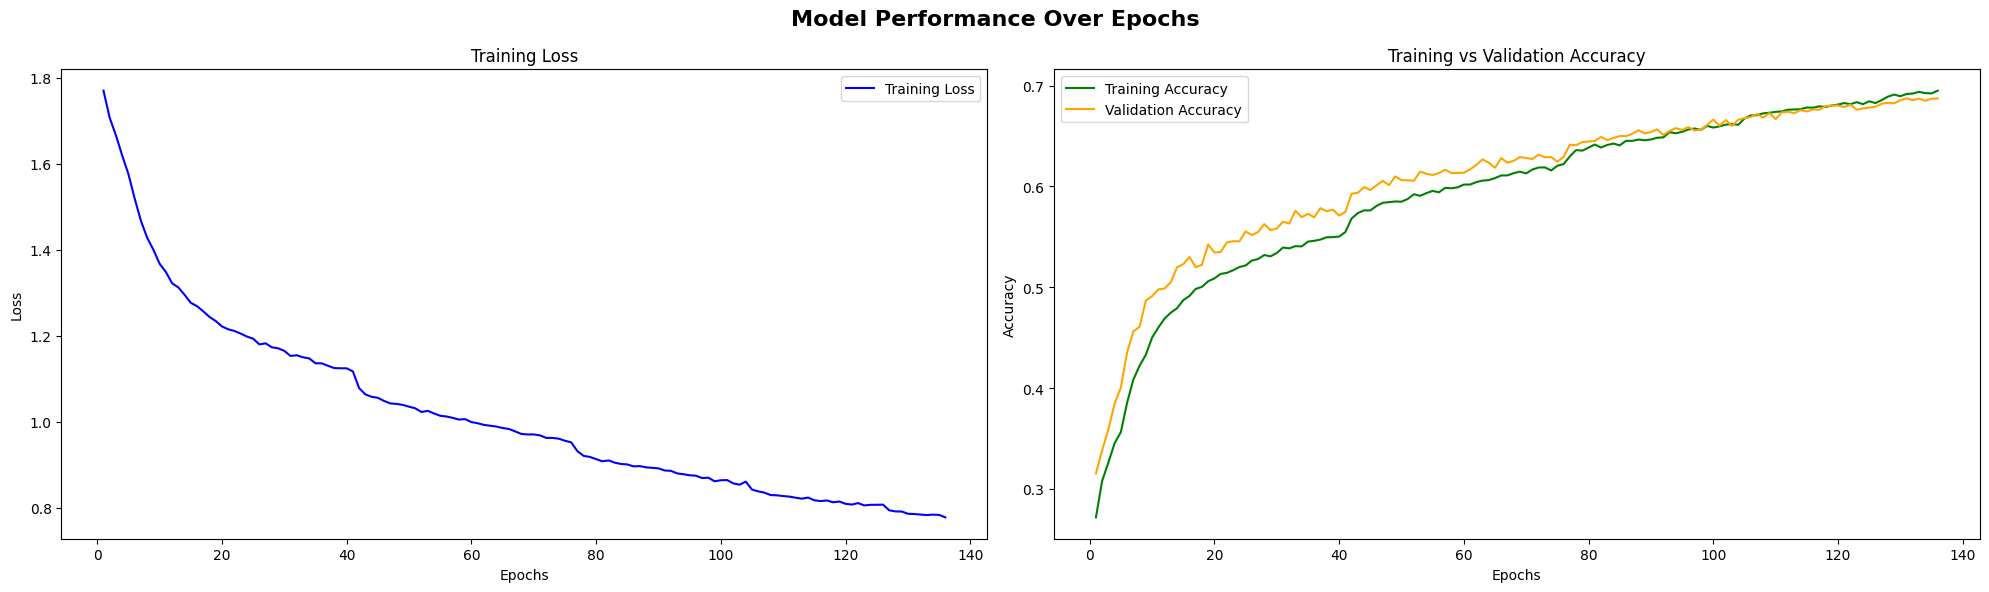

In [ ]:
plot_training_history(train_loss, train_acc, val_acc)

## Original model

In [ ]:
original_model.load_state_dict(torch.load('/content/model_166epochs_val_acc85.pt'))

<All keys matched successfully>

In [ ]:
original_accuracy = evaluate_model_accuracy(original_model, test_loader, device)

Accuracy of our model on test data: 85.55 %


In [ ]:
train_loss = [
    4349.92, 4096.23, 3945.03, 3821.11, 3659.75, 3558.52, 3402.40, 3298.30, 3197.57, 3135.54,
    3066.71, 2990.58, 2905.58, 2850.77, 2809.23, 2757.89, 2706.99, 2689.90, 2653.93, 2599.53,
    2580.79, 2552.48, 2518.69, 2506.51, 2462.73, 2437.65, 2416.77, 2393.76, 2372.57, 2340.47,
    2318.48, 2300.08, 2273.49, 2259.56, 2235.41, 2221.38, 2188.72, 2167.74, 2165.02, 2139.49,
    2120.92, 2107.29, 2078.12, 2052.58, 2035.20, 2023.40, 2003.90, 1995.22, 1987.46, 1961.18,
    1947.54, 1921.49, 1905.75, 1891.66, 1881.31, 1857.78, 1844.27, 1835.54, 1816.00, 1786.23,
    1776.02, 1758.89, 1757.84, 1729.63, 1716.89, 1708.09, 1688.97, 1672.04, 1662.17, 1658.25,
    1630.14, 1622.34, 1608.82, 1589.07, 1586.18, 1568.69, 1559.05, 1553.24, 1532.54, 1518.55,
    1509.71, 1500.25, 1486.92, 1478.09, 1464.14, 1453.23, 1439.26, 1288.93, 1243.70, 1222.17,
    1203.36, 1178.94, 1175.83, 1165.92, 1149.32, 1124.68, 1122.34, 1103.28, 1097.25, 1090.20,
    1079.31, 1075.41, 1058.95, 1047.95, 1040.95, 1040.31, 1020.37, 1019.62, 1015.87, 989.95,
    988.61, 986.72, 967.18, 984.03, 962.92, 956.40, 956.34, 868.69, 836.28, 832.05, 816.49,
    809.75, 804.24, 800.34, 795.34, 797.86, 770.34, 769.14, 785.13, 773.64, 764.46, 750.42,
    743.82, 748.52, 737.86, 701.82, 688.26, 684.58, 680.25, 673.77, 676.89, 666.42, 667.75,
    658.05, 663.27, 641.74, 630.28, 636.89, 637.25, 630.93, 630.54, 626.34, 625.93, 622.45,
    616.41, 606.63, 612.86, 601.97, 604.28, 607.49, 606.28, 611.37, 597.21, 601.56, 609.67
]

train_acc = [
    0.1648, 0.2069, 0.2365, 0.2558, 0.2932, 0.3152, 0.3476, 0.3641, 0.3819, 0.3924,
    0.4043, 0.4195, 0.4328, 0.4412, 0.4487, 0.4597, 0.4676, 0.4715, 0.4768, 0.4870,
    0.4908, 0.4980, 0.5015, 0.5055, 0.5118, 0.5179, 0.5224, 0.5252, 0.5286, 0.5354,
    0.5390, 0.5403, 0.5493, 0.5492, 0.5534, 0.5585, 0.5612, 0.5651, 0.5676, 0.5714,
    0.5762, 0.5769, 0.5821, 0.5892, 0.5909, 0.5915, 0.5979, 0.6003, 0.5994, 0.6058,
    0.6066, 0.6136, 0.6154, 0.6170, 0.6203, 0.6232, 0.6273, 0.6292, 0.6335, 0.6374,
    0.6388, 0.6447, 0.6449, 0.6494, 0.6530, 0.6542, 0.6583, 0.6618, 0.6642, 0.6635,
    0.6715, 0.6715, 0.6754, 0.6782, 0.6792, 0.6838, 0.6832, 0.6858, 0.6906, 0.6922,
    0.6940, 0.6961, 0.7007, 0.7013, 0.7018, 0.7072, 0.7082, 0.7379, 0.7474, 0.7527,
    0.7555, 0.7603, 0.7609, 0.7630, 0.7683, 0.7706, 0.7742, 0.7768, 0.7758, 0.7793,
    0.7817, 0.7845, 0.7873, 0.7885, 0.7906, 0.7904, 0.7941, 0.7943, 0.7955, 0.8012,
    0.8005, 0.8006, 0.8062, 0.8021, 0.8057, 0.8086, 0.8080, 0.8258, 0.8336, 0.8315,
    0.8356, 0.8379, 0.8382, 0.8392, 0.8411, 0.8385, 0.8444, 0.8448, 0.8438, 0.8445,
    0.8477, 0.8490, 0.8529, 0.8510, 0.8530, 0.8580, 0.8636, 0.8645, 0.8631, 0.8641,
    0.8665, 0.8663, 0.8657, 0.8677, 0.8671, 0.8723, 0.8751, 0.8736, 0.8722, 0.8742,
    0.8748, 0.8748, 0.8750, 0.8737, 0.8769, 0.8788, 0.8767, 0.8794, 0.8788, 0.8796,
    0.8785, 0.8785, 0.8807, 0.8793, 0.8789
]

val_acc = [
    0.2096, 0.2460, 0.2692, 0.3034, 0.3453, 0.3674, 0.4009, 0.4138, 0.4232, 0.4468,
    0.4533, 0.4669, 0.4817, 0.4882, 0.4905, 0.5035, 0.4972, 0.5065, 0.5127, 0.5181,
    0.5295, 0.5285, 0.5334, 0.5442, 0.5420, 0.5448, 0.5461, 0.5570, 0.5584, 0.5516,
    0.5749, 0.5762, 0.5781, 0.5768, 0.5857, 0.5829, 0.5927, 0.5940, 0.5886, 0.5933,
    0.5979, 0.5960, 0.6032, 0.6073, 0.6135, 0.6200, 0.6086, 0.6253, 0.6225, 0.6256,
    0.6201, 0.6320, 0.6242, 0.6402, 0.6512, 0.6425, 0.6434, 0.6426, 0.6555, 0.6466,
    0.6570, 0.6581, 0.6604, 0.6680, 0.6647, 0.6603, 0.6809, 0.6758, 0.6761, 0.6707,
    0.6820, 0.6889, 0.6884, 0.6799, 0.6918, 0.6820, 0.6966, 0.7001, 0.7005, 0.7076,
    0.6970, 0.7045, 0.7194, 0.7173, 0.7057, 0.7059, 0.7134, 0.7473, 0.7348, 0.7387,
    0.7526, 0.7535, 0.7585, 0.7603, 0.7540, 0.7730, 0.7671, 0.7685, 0.7744, 0.7751,
    0.7718, 0.7726, 0.7750, 0.7828, 0.7830, 0.7870, 0.7820, 0.7800, 0.7917, 0.7798,
    0.7865, 0.7777, 0.8002, 0.7904, 0.7954, 0.7936, 0.8001, 0.8138, 0.8181, 0.8230,
    0.8228, 0.8186, 0.8231, 0.8265, 0.8193, 0.8258, 0.8282, 0.8301, 0.8319, 0.8253,
    0.8351, 0.8297, 0.8323, 0.8330, 0.8346, 0.8429, 0.8415, 0.8421, 0.8424, 0.8444,
    0.8475, 0.8456, 0.8421, 0.8432, 0.8471, 0.8498, 0.8494, 0.8518, 0.8525, 0.8530,
    0.8507, 0.8526, 0.8519, 0.8486, 0.8543, 0.8545, 0.8542, 0.8539, 0.8533, 0.8555,
    0.8554, 0.8539, 0.8553, 0.8526, 0.8543
]

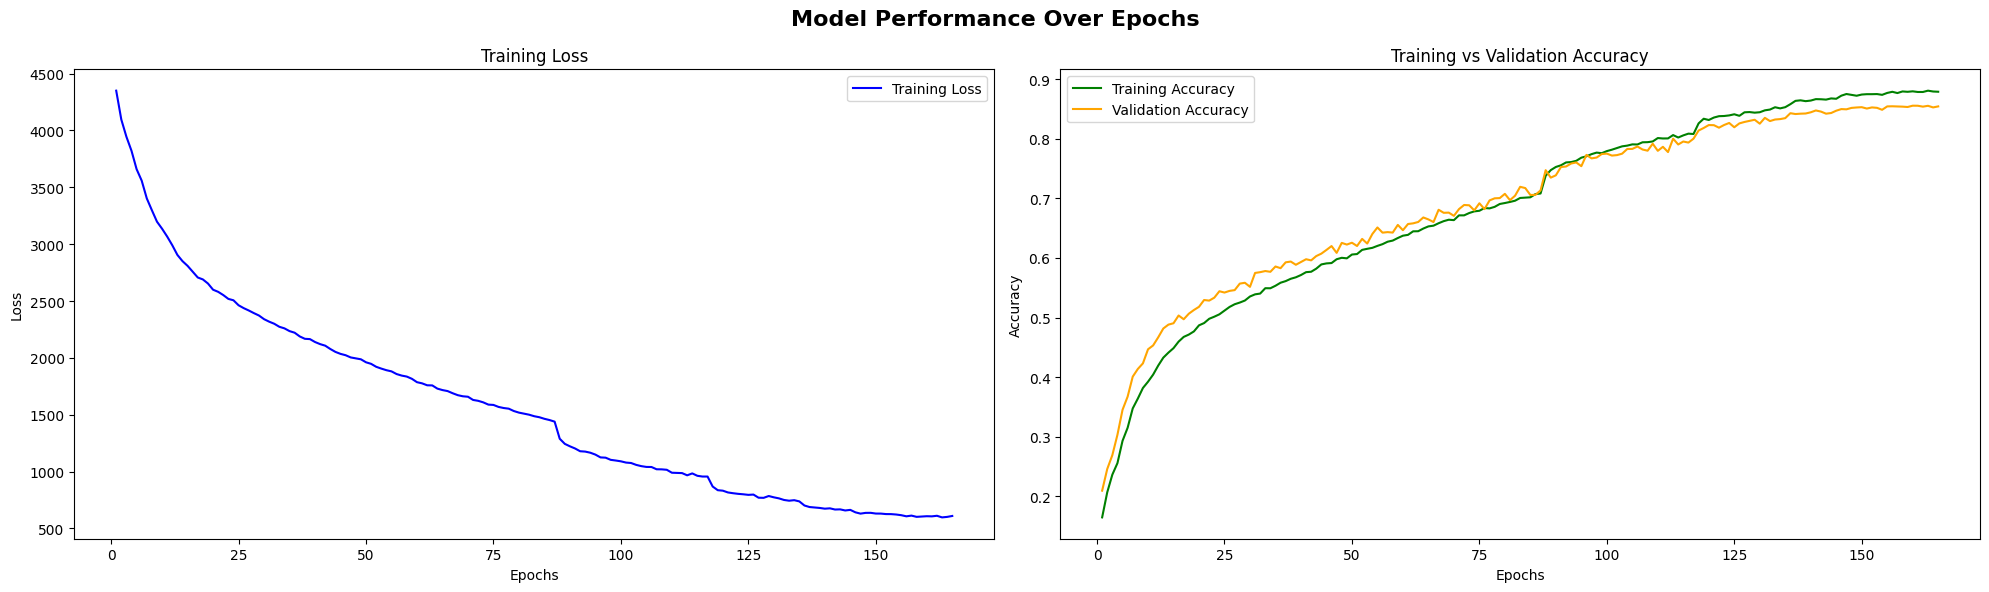

In [ ]:
plot_training_history(train_loss, train_acc, val_acc)

## 5CNN model

In [ ]:
cnn5_model = CNN_BiLSTM(
    input_shape=(x_train_tensor.shape[1], x_train_tensor.shape[2]),
    num_classes=len(set(y_train_tensor.tolist())),
    num_cnn_layers=5,
    cnn_filters=256,
    use_batch_norm=True
).to(device)

In [ ]:
cnn5_model.load_state_dict(torch.load('/content/model_5cnn_1lstm_acc68.pt'))

<All keys matched successfully>

In [ ]:
cnn5_accuracy = evaluate_model_accuracy(cnn5_model, test_loader, device)

Accuracy of our model on test data: 71.74 %


## Compare 3 Models

/tmp/ipython-input-28-210847805.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Model', y='Accuracy (%)', palette='Set2')


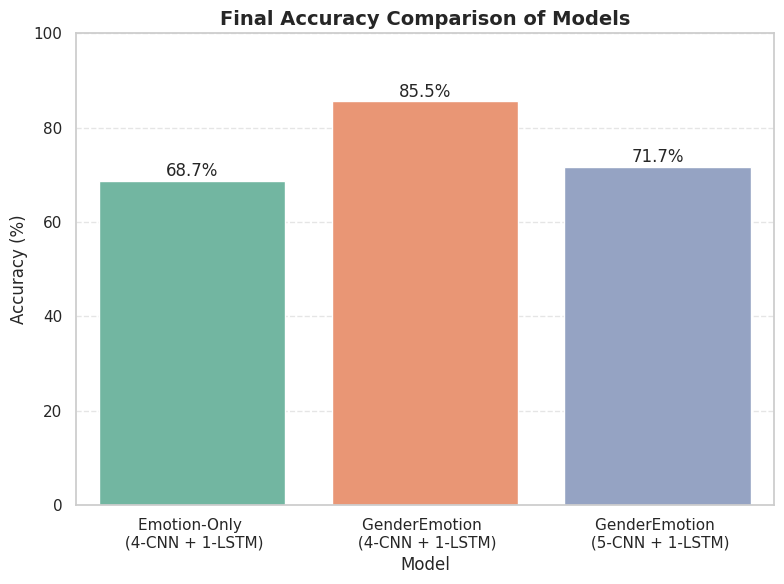

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Example data — replace with your actual model names and accuracies
data = {
    'Model': ['Emotion-Only \n (4-CNN + 1-LSTM)', 'GenderEmotion \n (4-CNN + 1-LSTM)', 'GenderEmotion \n (5-CNN + 1-LSTM)'],
    'Accuracy': [emotion_accuracy, original_accuracy, cnn5_accuracy]  # In decimal format
}

# Create DataFrame
df = pd.DataFrame(data)
df['Accuracy (%)'] = df['Accuracy'] * 100

# Seaborn bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x='Model', y='Accuracy (%)', palette='Set2')

# Add value labels
for index, row in df.iterrows():
    plt.text(index, row['Accuracy (%)'] + 1, f"{row['Accuracy (%)']:.1f}%", ha='center')

plt.title('Final Accuracy Comparison of Models', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Evaluation

In [ ]:
def evaluate_model(model, test_loader, label_encoder, device='cuda'):
    """
    Evaluates a trained model on a test set and returns a DataFrame
    containing predicted and actual string labels.

    Parameters:
    - model: Trained PyTorch model.
    - test_loader: DataLoader with test data.
    - label_encoder: Fitted sklearn LabelEncoder instance.
    - device: 'cpu' or 'cuda' depending on hardware.

    Returns:
    - final_df: DataFrame with 'PredictedLabels' and 'ActualLabels'.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(x_batch)
            preds = outputs.argmax(dim=1).cpu().numpy()
            labels = y_batch.cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    # Inverse transform to get original string labels
    y_pred_labels = label_encoder.inverse_transform(np.array(all_preds).reshape(-1, 1))
    y_true_labels = label_encoder.inverse_transform(np.array(all_labels).reshape(-1, 1))

    # Create DataFrame
    final_df = pd.DataFrame({
        'PredictedLabels': y_pred_labels.flatten(),
        'ActualLabels': y_true_labels.flatten()
    })

    return final_df


In [ ]:
def evaluate_emotion_predictions(final_df, map_emotion=True, title="Confusion Matrix"):
    """
    Evaluates emotion predictions by mapping gendered labels to neutral forms,
    calculating accuracy, and plotting a confusion matrix.

    Parameters:
    - final_df: pd.DataFrame with 'ActualLabels' and 'PredictedLabels' columns.
    - title: Title for the confusion matrix plot (optional).

    Returns:
    - acc: Accuracy score (float).
    - cm: Confusion matrix (np.ndarray).
    - modidf: Modified DataFrame with mapped labels.
    """
    # Mapping gendered emotions to neutral
    modidf = final_df.copy()

    if map_emotion:
      emotion_map = {
          f"{g}_{e}": e for g in ['male', 'female']
          for e in ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
      }

      # Apply mapping
      modidf['ActualLabels'] = modidf['ActualLabels'].replace(emotion_map)
      modidf['PredictedLabels'] = modidf['PredictedLabels'].replace(emotion_map)

    # Accuracy
    acc = accuracy_score(modidf['ActualLabels'], modidf['PredictedLabels'])
    print("Accuracy of our model on test data based on emotions:", round(acc * 100, 2), "%")

    # Confusion matrix
    classes = sorted(modidf['ActualLabels'].unique())
    cm = confusion_matrix(modidf['ActualLabels'], modidf['PredictedLabels'], labels=classes)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.heatmap(pd.DataFrame(cm, index=classes, columns=classes),
                annot=True, fmt='d', cmap='Blues', linewidths=1, linecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("Actual Label", fontsize=12)
    plt.tight_layout()
    plt.show()

    return acc, cm, modidf


## Evaluate original model

In [ ]:
final_df = evaluate_model(original_model, test_loader, label_encoder, device=device)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of our model on test data based on emotions: 86.39 %


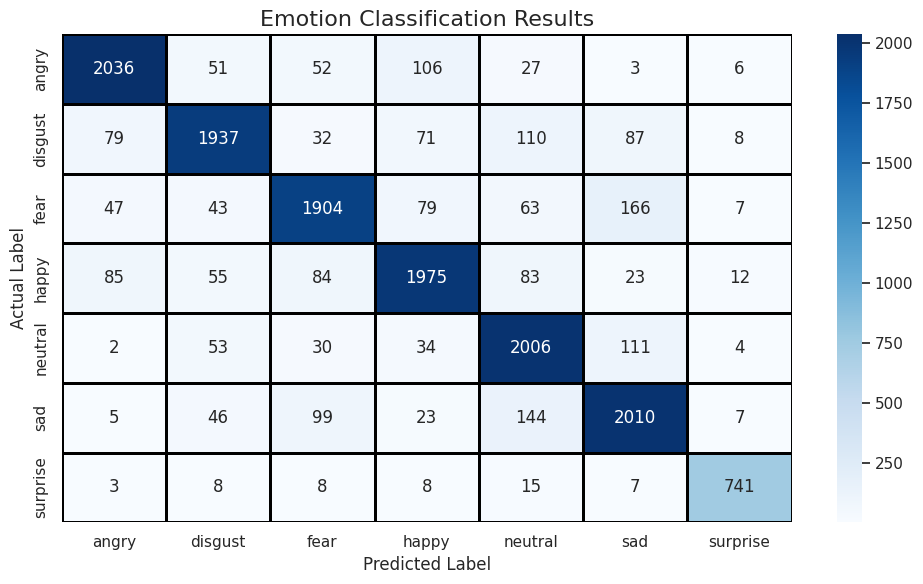

In [ ]:
acc, cm, modidf = evaluate_emotion_predictions(final_df, title="Emotion Classification Results")

In [ ]:
print(cm)

[[2036   51   52  106   27    3    6]
 [  79 1937   32   71  110   87    8]
 [  47   43 1904   79   63  166    7]
 [  85   55   84 1975   83   23   12]
 [   2   53   30   34 2006  111    4]
 [   5   46   99   23  144 2010    7]
 [   3    8    8    8   15    7  741]]


In [ ]:
# Print classification report
print("Classification Report:\n")
print(classification_report(modidf['ActualLabels'], modidf['PredictedLabels']))

Classification Report:

              precision    recall  f1-score   support

       angry       0.90      0.89      0.90      2281
     disgust       0.88      0.83      0.86      2324
        fear       0.86      0.82      0.84      2309
       happy       0.86      0.85      0.86      2317
     neutral       0.82      0.90      0.86      2240
         sad       0.84      0.86      0.85      2334
    surprise       0.94      0.94      0.94       790

    accuracy                           0.86     14595
   macro avg       0.87      0.87      0.87     14595
weighted avg       0.86      0.86      0.86     14595



## Gender-only model

In [ ]:
final_df1 = evaluate_model(emotion_model, emotion_test_loader, emotion_label_encoder, device=device)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of our model on test data based on emotions: 68.74 %


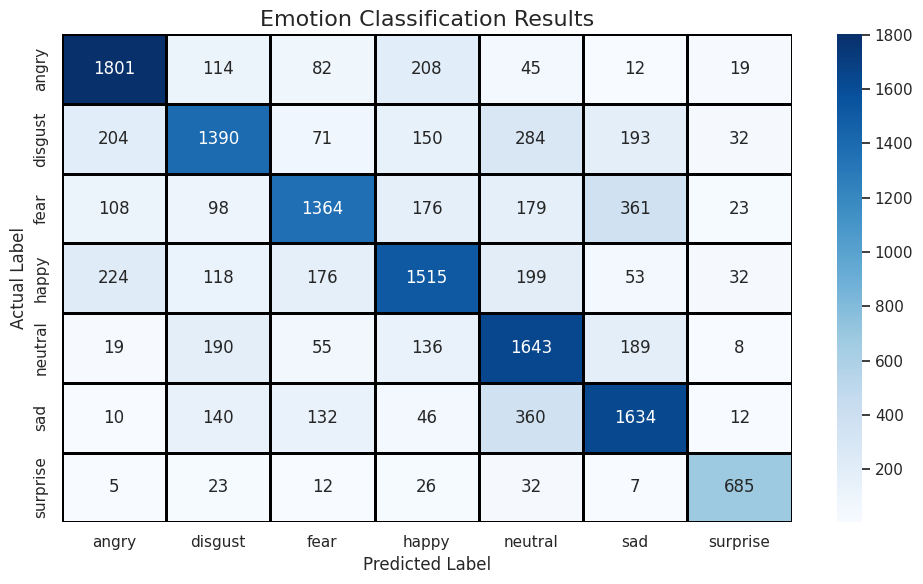

In [ ]:
acc1, cm1, modidf1 = evaluate_emotion_predictions(final_df1, title="Emotion Classification Results")

In [ ]:
# Print classification report
print("Classification Report:\n")
print(classification_report(modidf1['ActualLabels'], modidf1['PredictedLabels']))


Classification Report:

              precision    recall  f1-score   support

       angry       0.76      0.79      0.77      2281
     disgust       0.67      0.60      0.63      2324
        fear       0.72      0.59      0.65      2309
       happy       0.67      0.65      0.66      2317
     neutral       0.60      0.73      0.66      2240
         sad       0.67      0.70      0.68      2334
    surprise       0.84      0.87      0.86       790

    accuracy                           0.69     14595
   macro avg       0.70      0.70      0.70     14595
weighted avg       0.69      0.69      0.69     14595



In [ ]:
print(cm1)

[[383  39  14  35   9   0  13]
 [ 39 313  14  33  93  41  23]
 [ 22  26 342  32  40  62  16]
 [ 42  37  58 300  63   8  26]
 [  3  39  10  25 463  44   9]
 [  1  23  25  20 108 289  11]
 [  4  19   2   7  29   0 143]]


## Compare the 2 models

In [ ]:
# Convert diagonals and row sums into per-class accuracy
model_a_acc = cm.diagonal() / cm.sum(axis=1)
model_b_acc = cm1.diagonal() / cm1.sum(axis=1)

# Optional: convert to percentage
model_a_acc = model_a_acc * 100
model_b_acc = model_b_acc * 100


In [ ]:
# Your class names
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Combine into a DataFrame for seaborn
df = pd.DataFrame({
    'Emotion': classes * 2,
    'Accuracy': list(model_a_acc) + list(model_b_acc),
    'Model': ['Model A'] * len(classes) + ['Model B'] * len(classes)
})


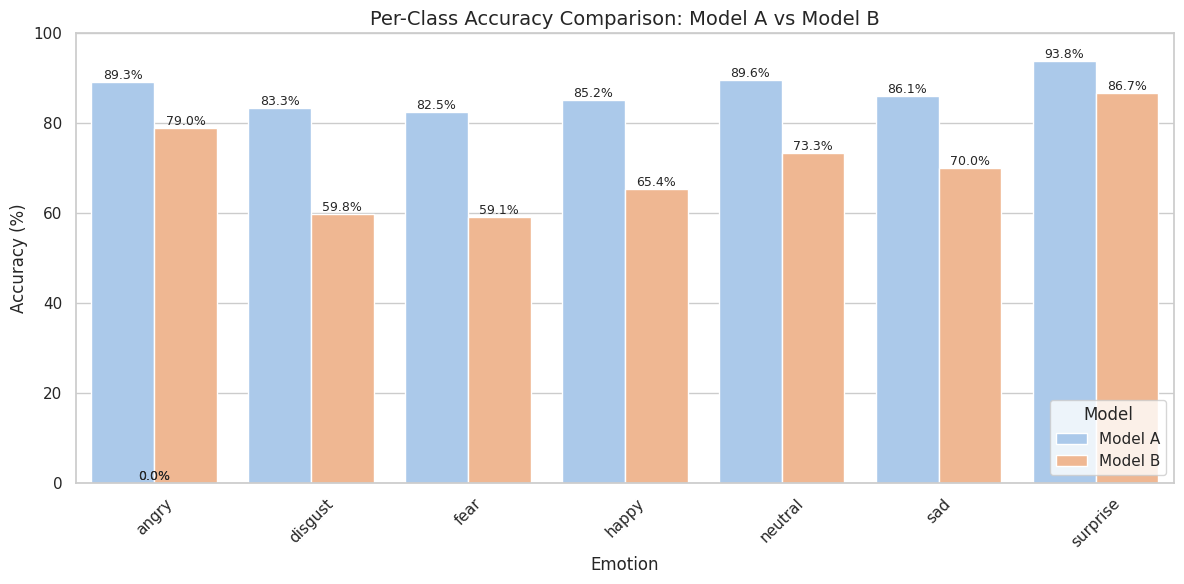

In [ ]:
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=df, x='Emotion', y='Accuracy', hue='Model', palette='pastel')

# Add value labels on top of each bar
for p in barplot.patches:
    height = p.get_height()
    barplot.annotate(f'{height:.1f}%',                 # one decimal point
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom', fontsize=9)

# Update legend title
plt.legend(title='Model')  # Change this to whatever label you prefer

# Axis and title formatting
plt.title('Per-Class Accuracy Comparison: Model A vs Model B', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
